In [4]:
import os
import sys
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.optimize
from scipy.signal import welch, firwin, filtfilt, hilbert
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency
from time import gmtime
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.cluster import KMeans
from scipy.stats import wilcoxon
from scipy.signal import correlate

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['correlate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries

In [6]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2)

dG - отклонение ускорения в момент измерения от 0 (ускорения свободного падения); если животное падает, то ускорение животного равно G и соответственно dG будет равно 1

dF1, dF2 - изменение направления вектора ускорения, причем dF1 - изменение за время между двумя измерениями (1 минута), а  dF2 - изменение между двумя измерениями с интервалом 1 мс - если оно не равно 0, то обычно животное изменяет свое положение.
 
Все показатели измеряются раз в минуту, если период измерения  указан больше, чем минута, то показатели усредняются за этот период. Если надо, то изготовитель может прислать точную формулу расчета этих показателей.

In [7]:
polygraphy_file = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_without_torpor.csv"
eeg_path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/"
data = pd.read_csv(polygraphy_file)

In [5]:
fs = 250

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/31-01-2019_13-39.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-72-956c0f31eb66>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/25-01-2019_19-20.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-72-956c0f31eb66>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/04-02-2019_13-34.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-72-956c0f31eb66>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/28-01-2019_15-40.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-72-956c0f31eb66>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/01-02-2019_14-58.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-72-956c0f31eb66>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/29-01-2019_15-53.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-72-956c0f31eb66>:19: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(eeg_path+name)


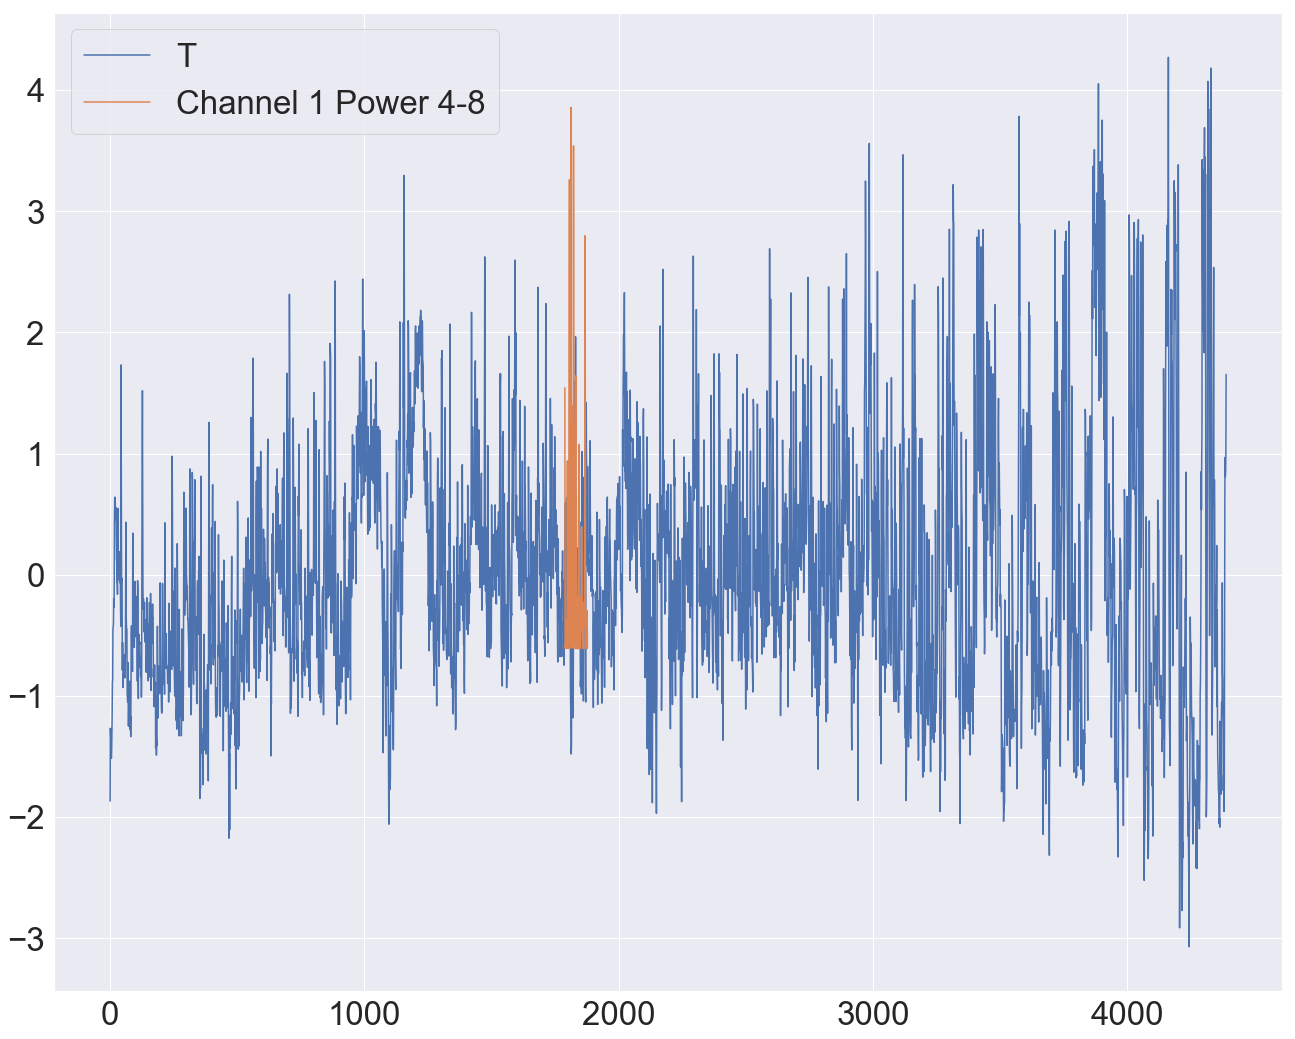

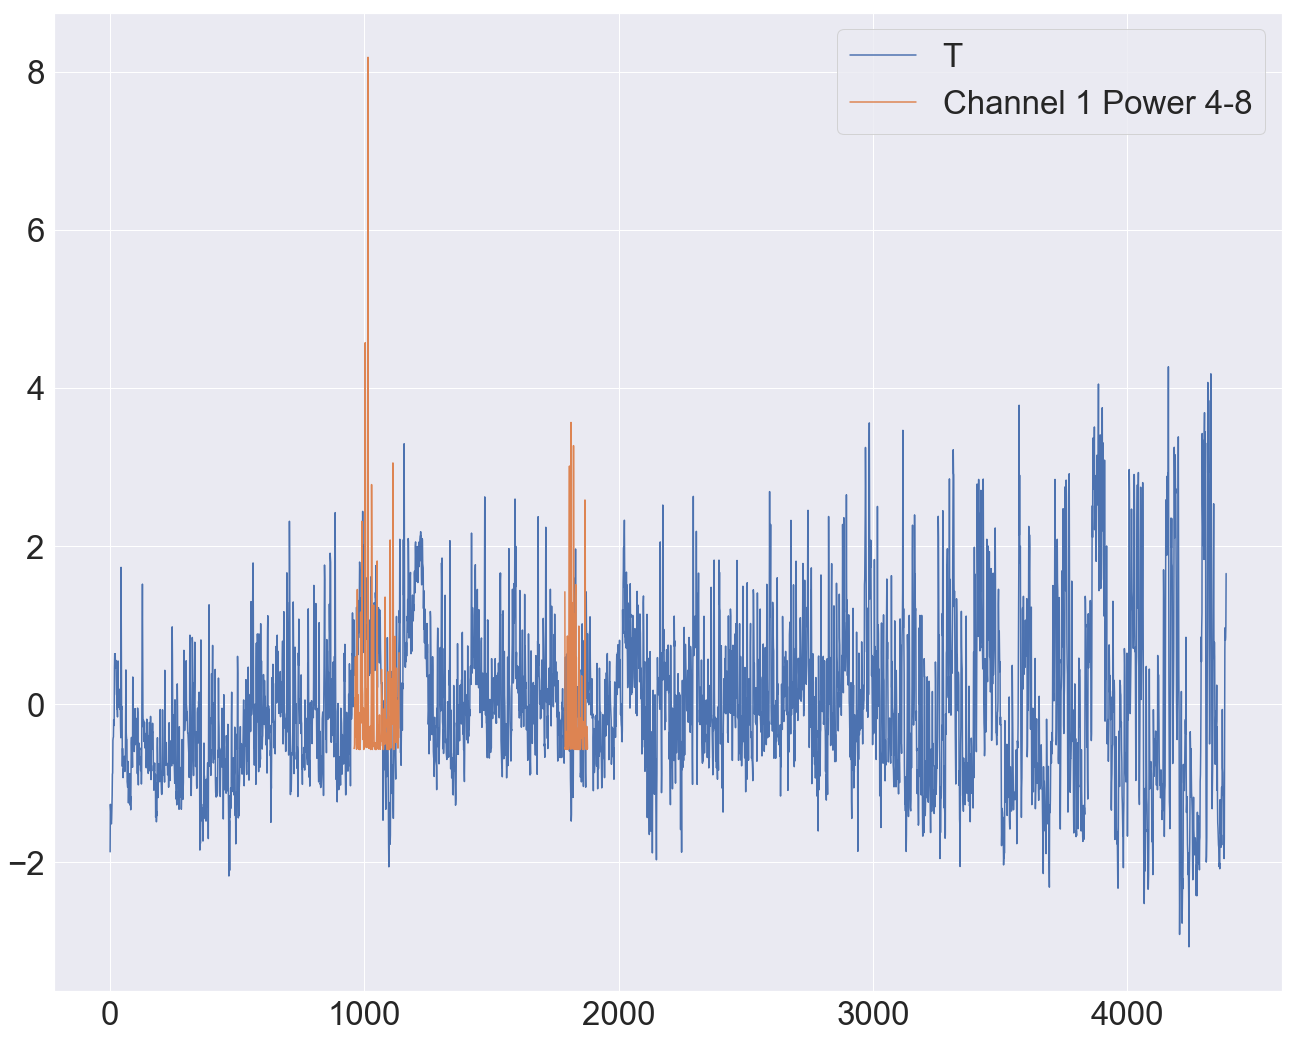

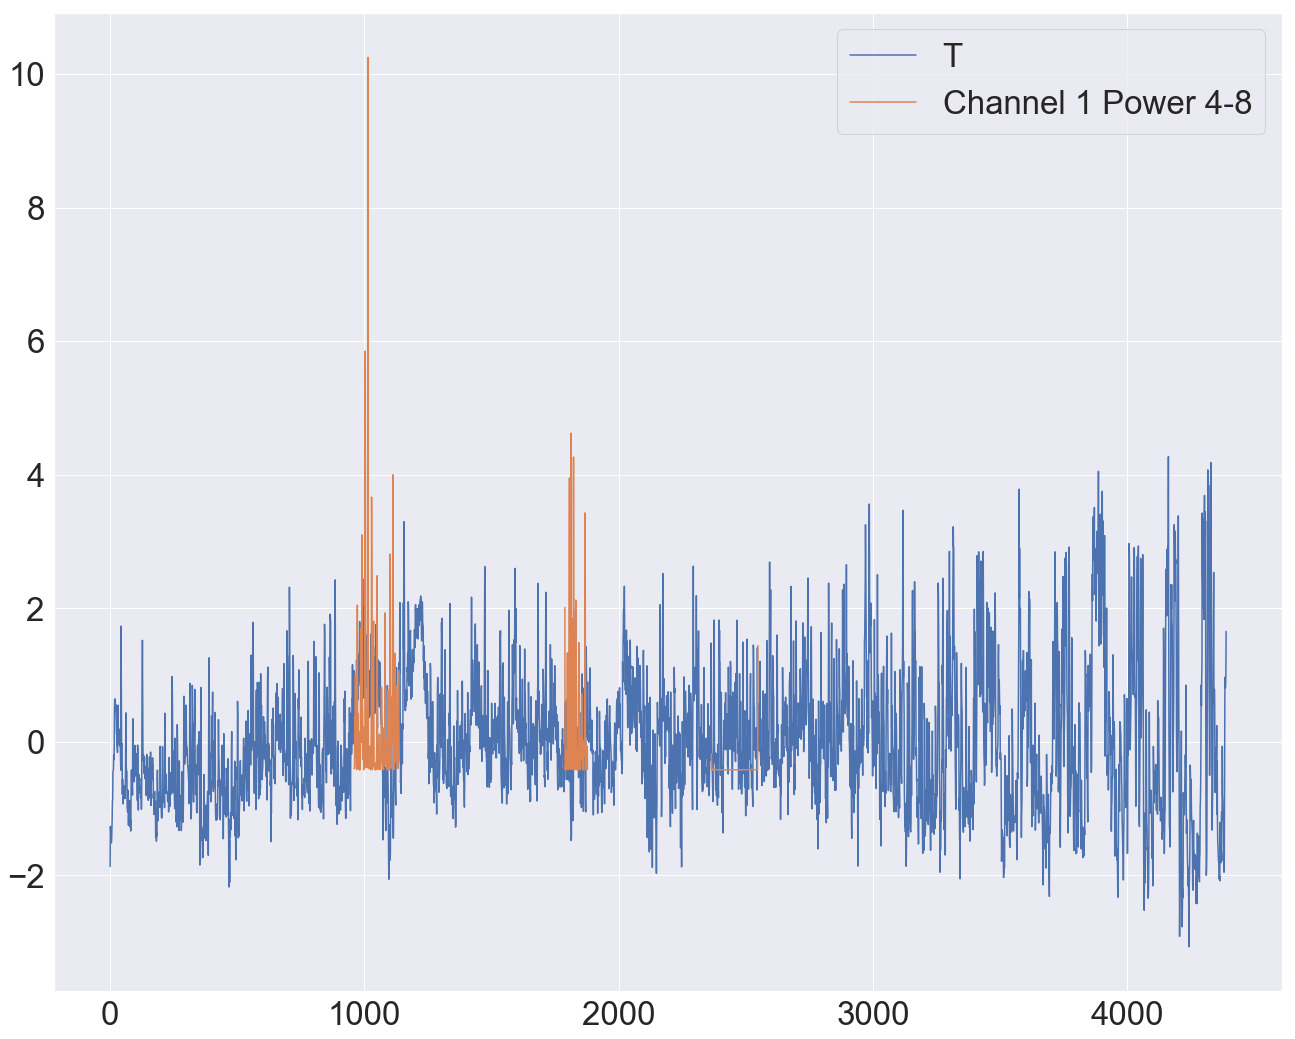

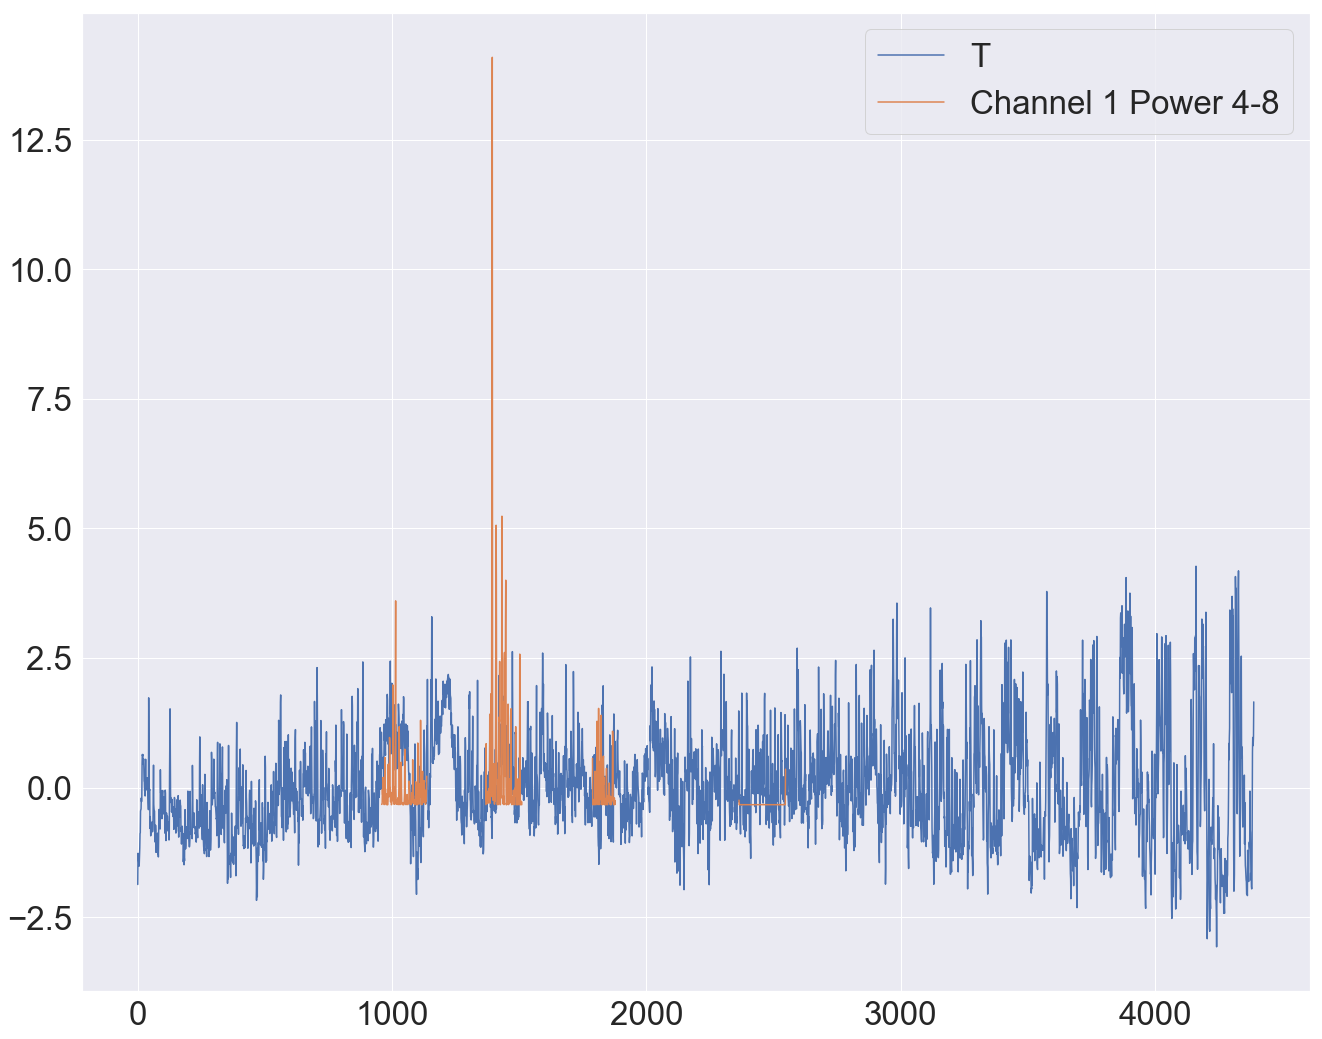

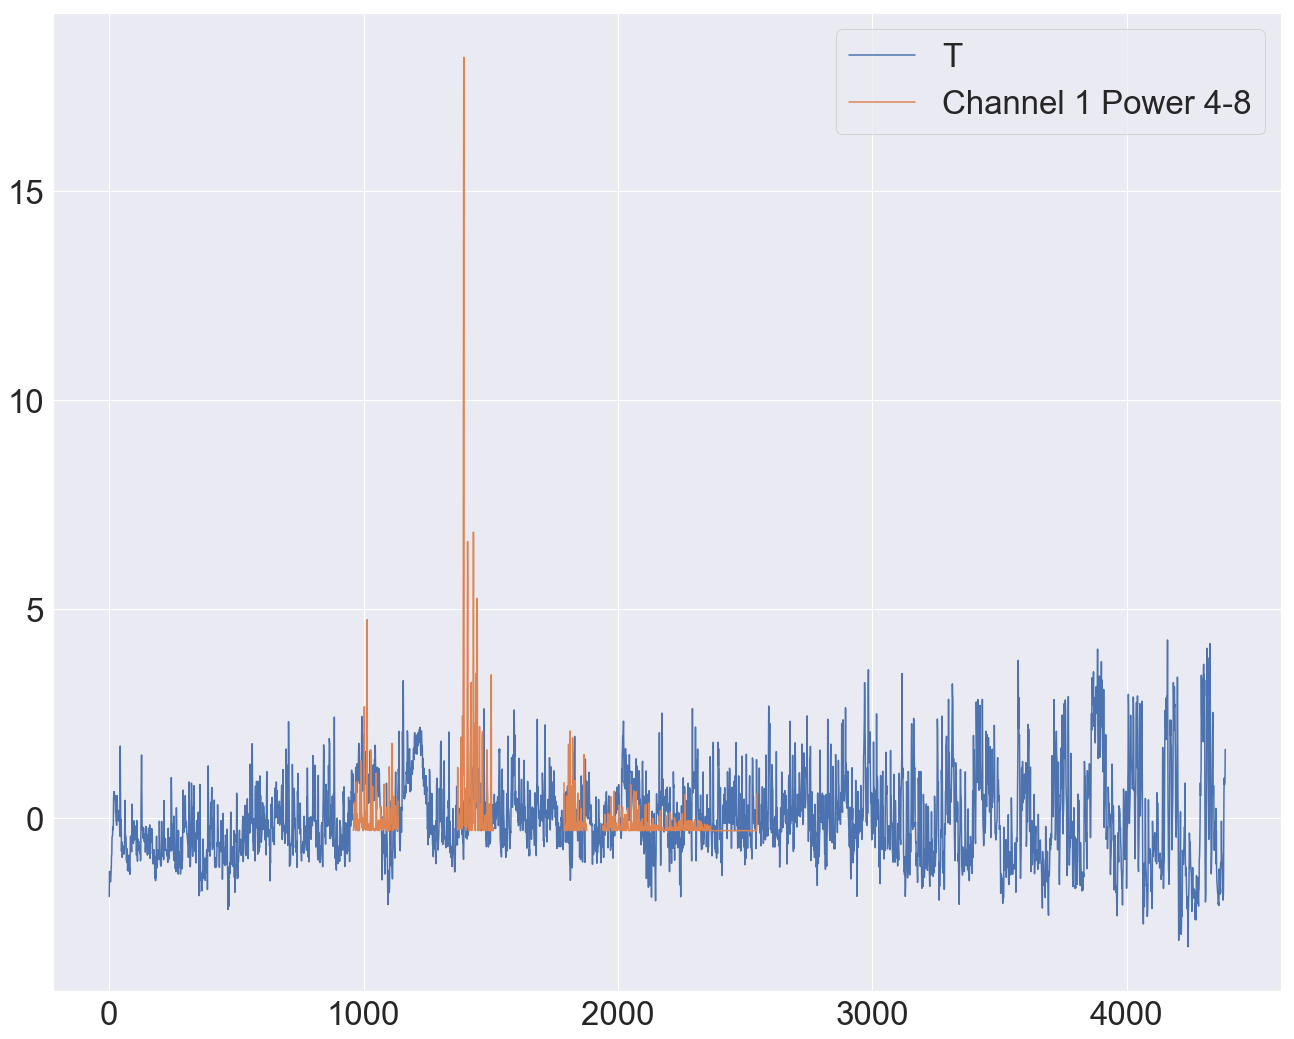

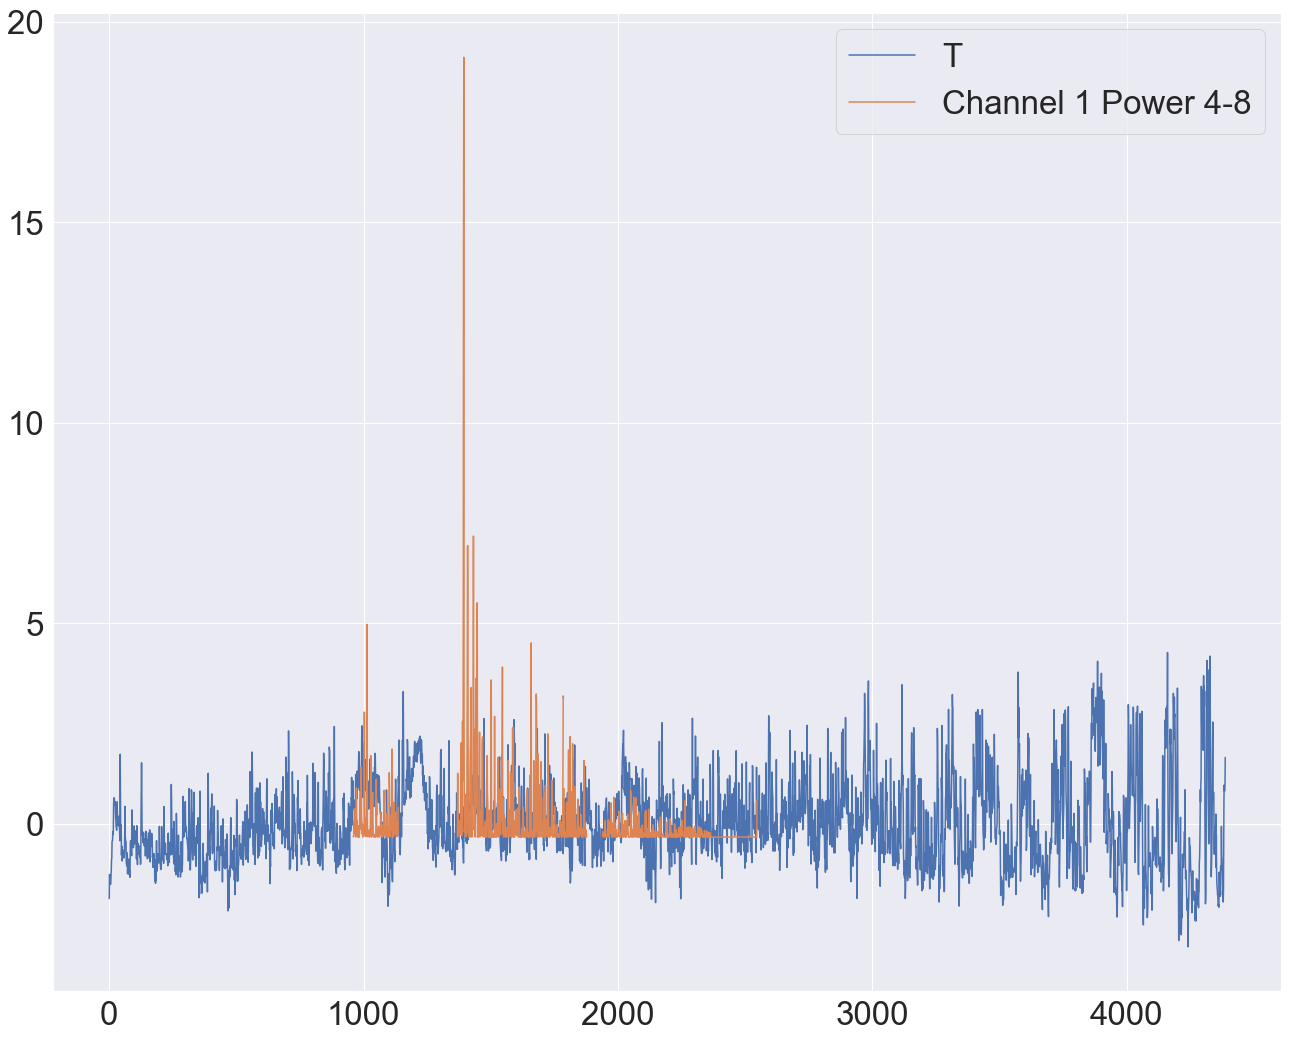

In [72]:
min_per_epoch = 10
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]])
data["EEG"] = 0
chans = ["Channel 1", "Channel 2"]
kinds = ["Power", 
         "Power {}-{}".format(bands[0,0], bands[0,1]), 
         "Power {}-{}".format(bands[1,0], bands[1,1])
        ]

for chan in chans:
    for kind in kinds:
        data["{} {}".format(chan, kind)] = np.nan
        
for name in os.listdir(eeg_path):

    # read EEG and acceleration data
    raw_data = mne.io.read_raw_edf(eeg_path+name)
    fs = round(raw_data.info['sfreq'])
    df = pd.DataFrame(raw_data.get_data([0, 1]), index=[chans[0], chans[1]]).T
        
    # get the time when the recording was started
    start = list(gmtime(raw_data.info['meas_date'][0]))

    # Calculate number of samples to skip till the begining of the epoch. 
    # This step is needed due to the fact, that EEG recording starts not at the same time as polygraph recording. 
    n_skip, corrected_start_time = count_damaged_samples(start, fs, 5)

    # Skip damaged samples at the begining
    df_new = df.iloc[n_skip:, ]

    # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
    n_epocs = int(np.floor(df_new.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
    n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

    # Skip damaged samples at the ending
    df_epocs = df_new.iloc[:n_samples, :]

    # Find start epoch index
    start_epoc = data[
        (data['Year']==start[0]) &
        (data['Month']==start[1])&
        (data['Day']==start[2])  &
        (data['Hour']==start[3]) &
        (data['Minute']==start[4])
        ].index[0]
    
    # Polygraphy epoch length in EEG samples.
    step = fs*SEC_PER_MIN*min_per_epoch

    for chan in chans:
        
        b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
        df_epocs_low = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter

        b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
        df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])

        sum_power = np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
        sum_power_low = np.array(list(map(lambda i: (df_epocs_low[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
        sum_power_hi = np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
        
        data["{} {}".format(chan, kinds[0])].iloc[start_epoc:start_epoc+n_epocs] = sum_power*1e3
        data["{} {}".format(chan, kinds[1])].iloc[start_epoc:start_epoc+n_epocs] = sum_power_low*1e3
        data["{} {}".format(chan, kinds[2])].iloc[start_epoc:start_epoc+n_epocs] = sum_power_hi*1e3
        
        del df_epocs_low, df_epocs_hi, sum_power_low, sum_power_hi, sum_power
        
    del raw_data, df, df_new

In [100]:
time_array = data.dropna().index/6/24

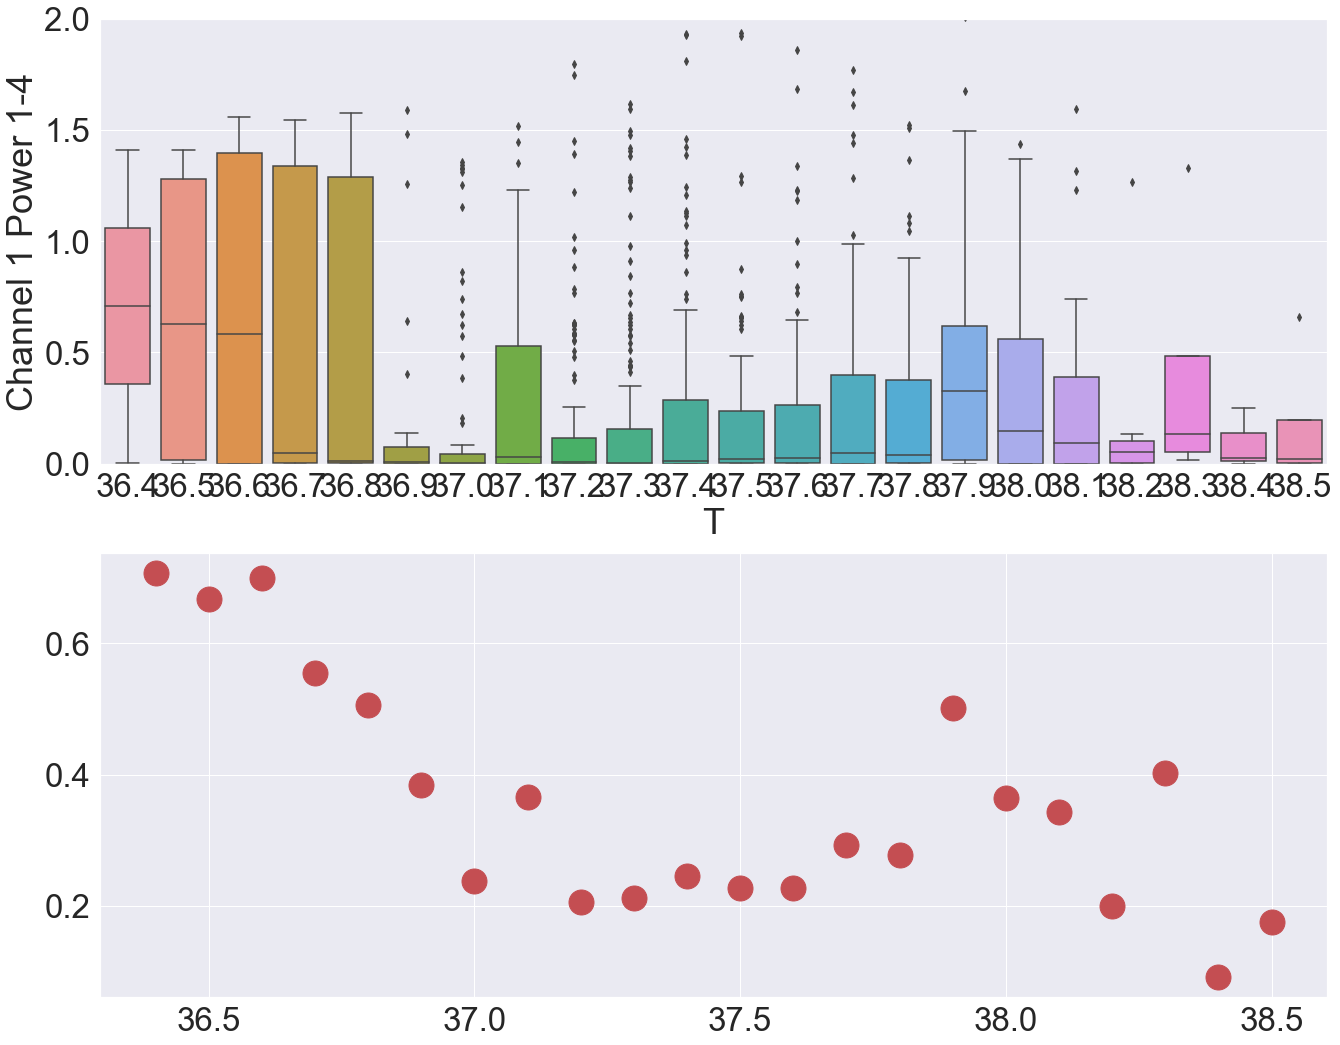

In [213]:
temp = data.dropna().copy()    
temp["T"] = round(temp["T"], 1)

new = []
for i in temp["T"].unique():
    new.append(temp[temp["T"] == i][["Channel 1 Power 1-4"]].mean())

subplot(2,1,1)
sns.boxplot(x="T", y="Channel 1 Power 1-4", data=temp,    )
plt.ylim([0, 2])
subplot(2,1,2)
plt.plot(temp["T"].unique(), new, "r.", markersize=50)
plt.show()

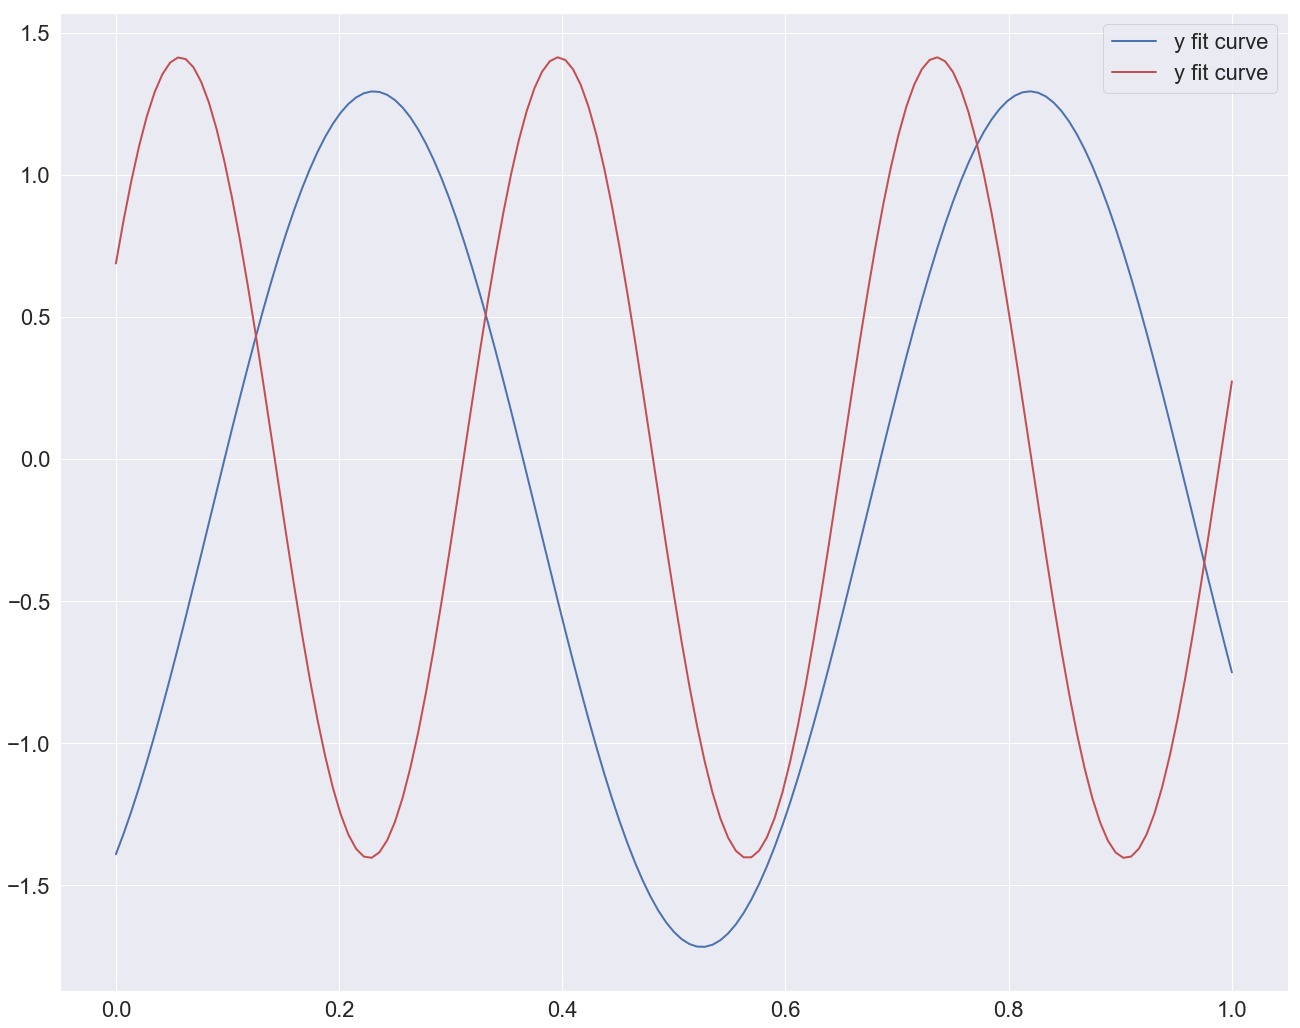

[2.2122961224657924]
[-1342.2110424576656]
[0.04928357751234016]


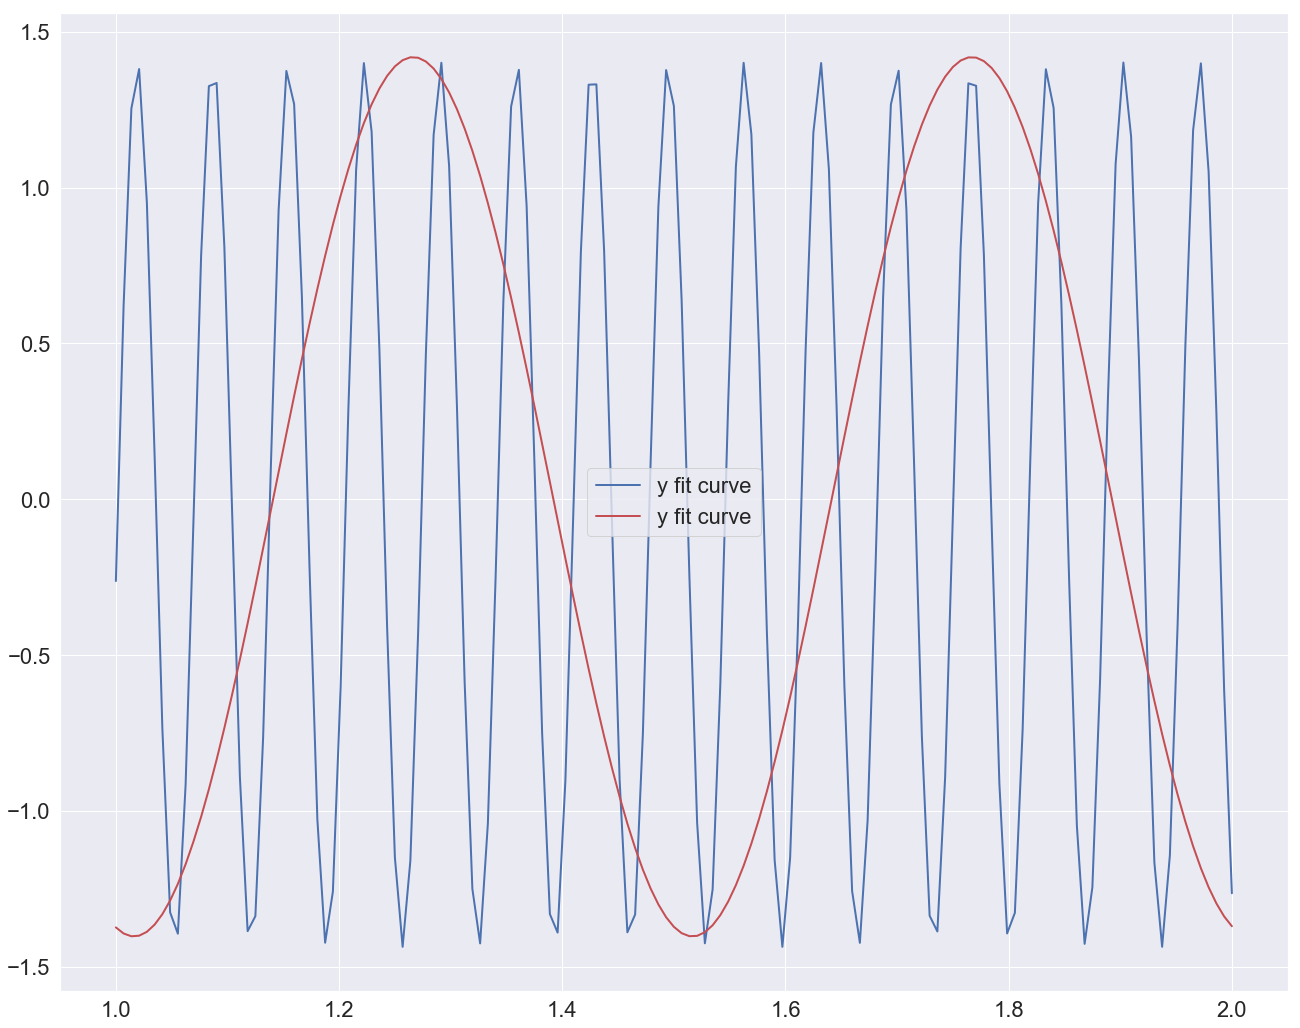

[2.2122961224657924, 2.045211161733851]
[-1342.2110424576656, -1332.5050455622188]
[0.04928357751234016, 0.028227941794938132]


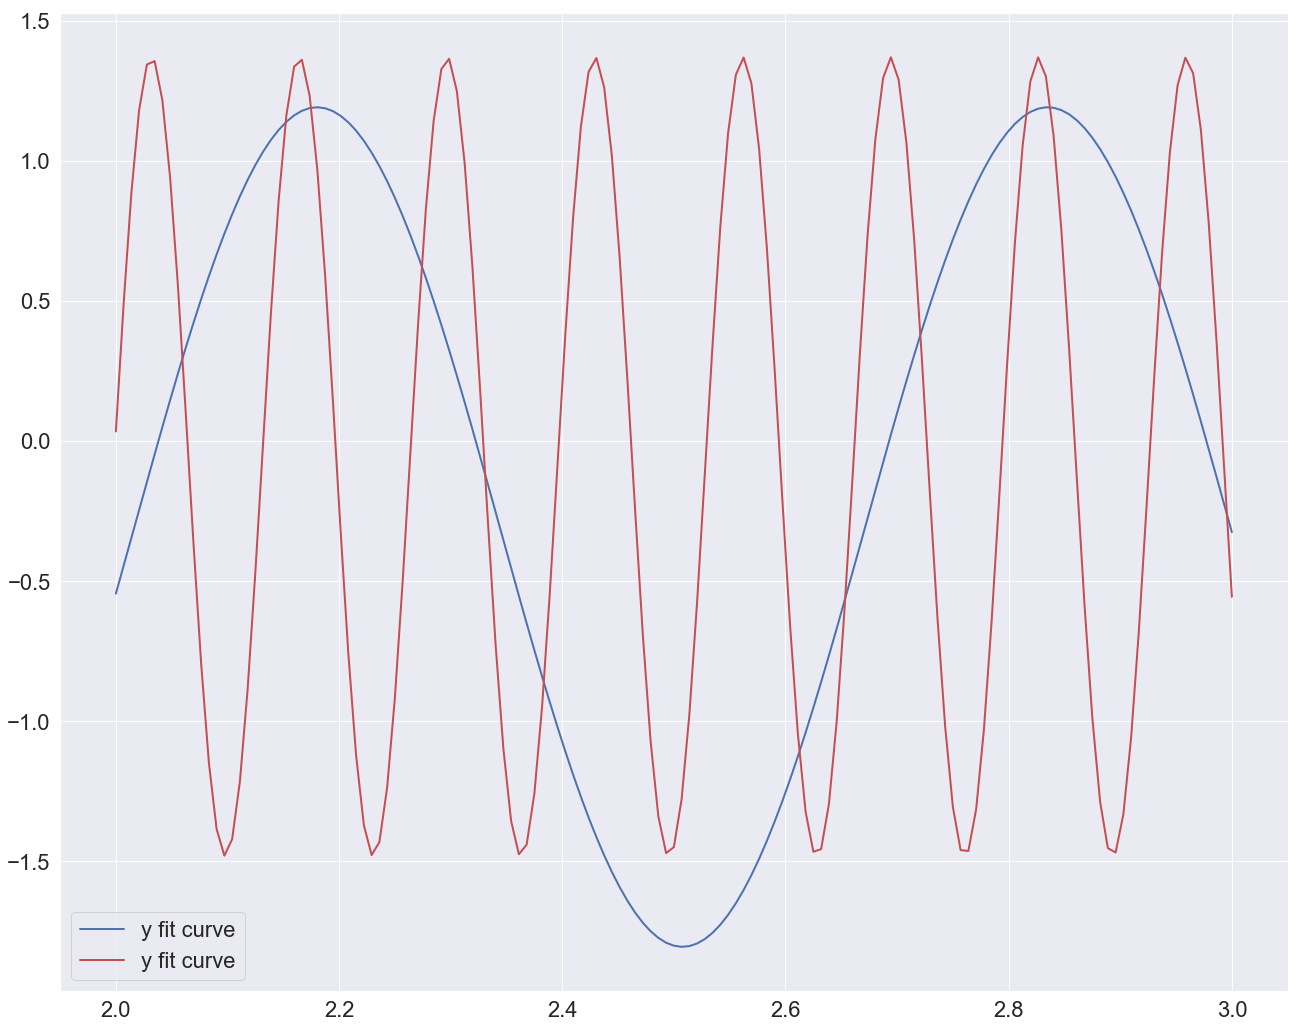

[2.2122961224657924, 2.045211161733851, 2.044516113200298]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751]


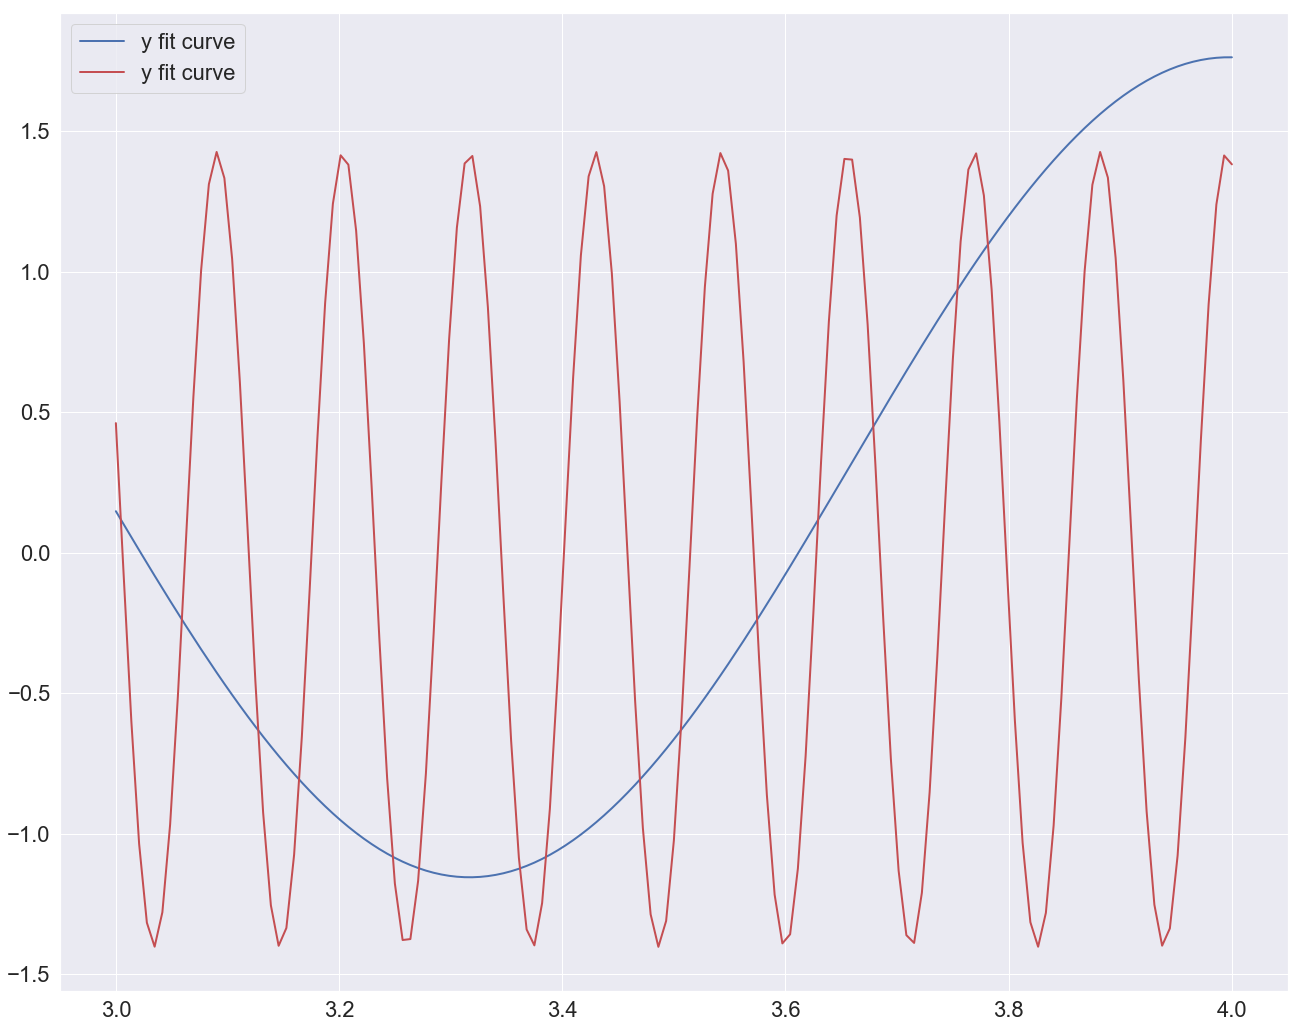

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039]


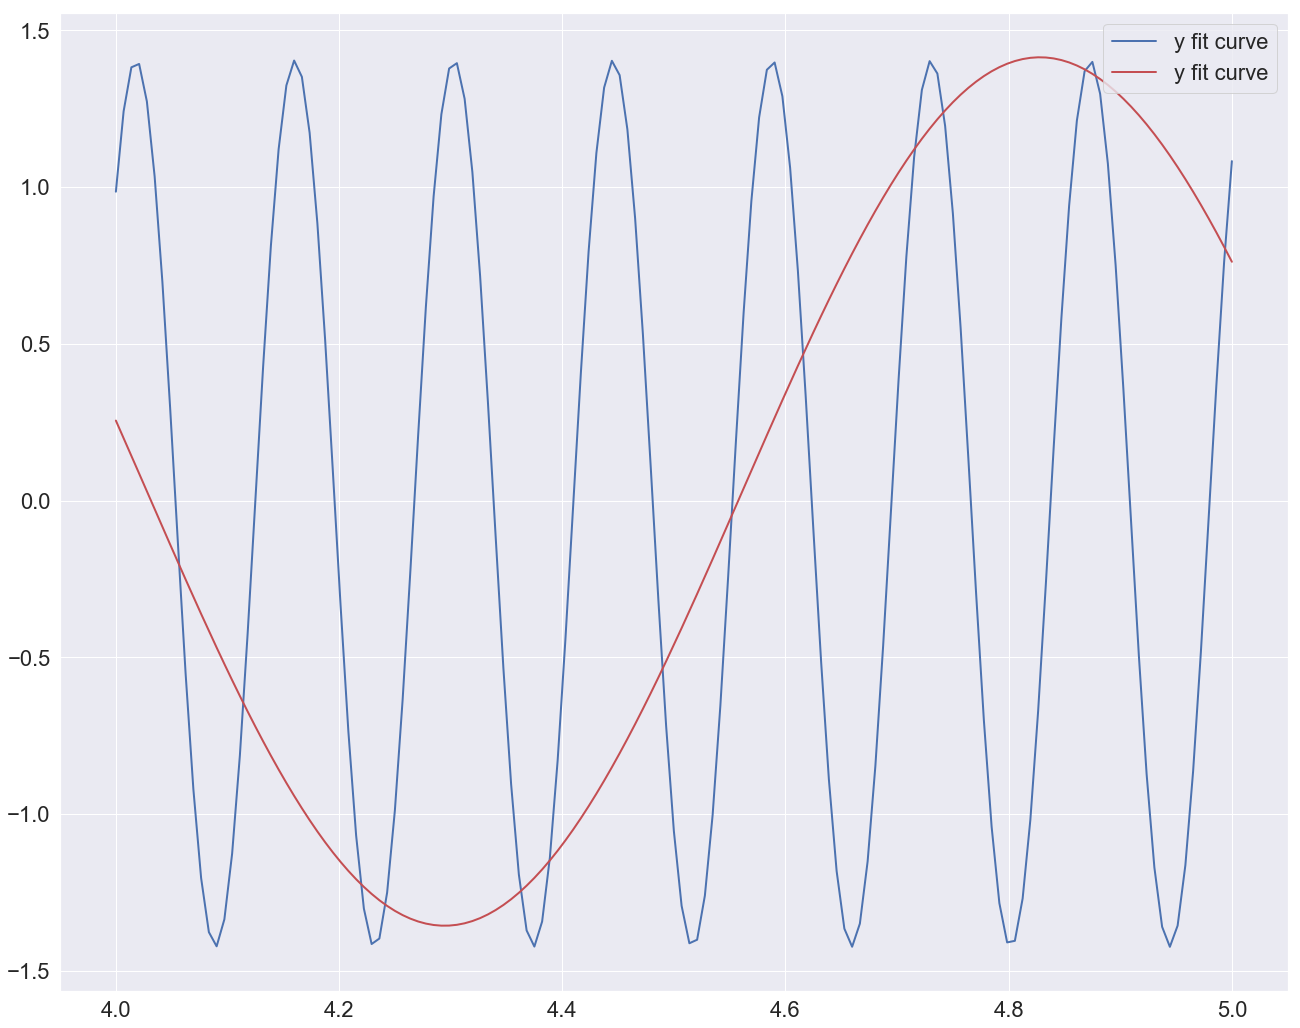

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775]


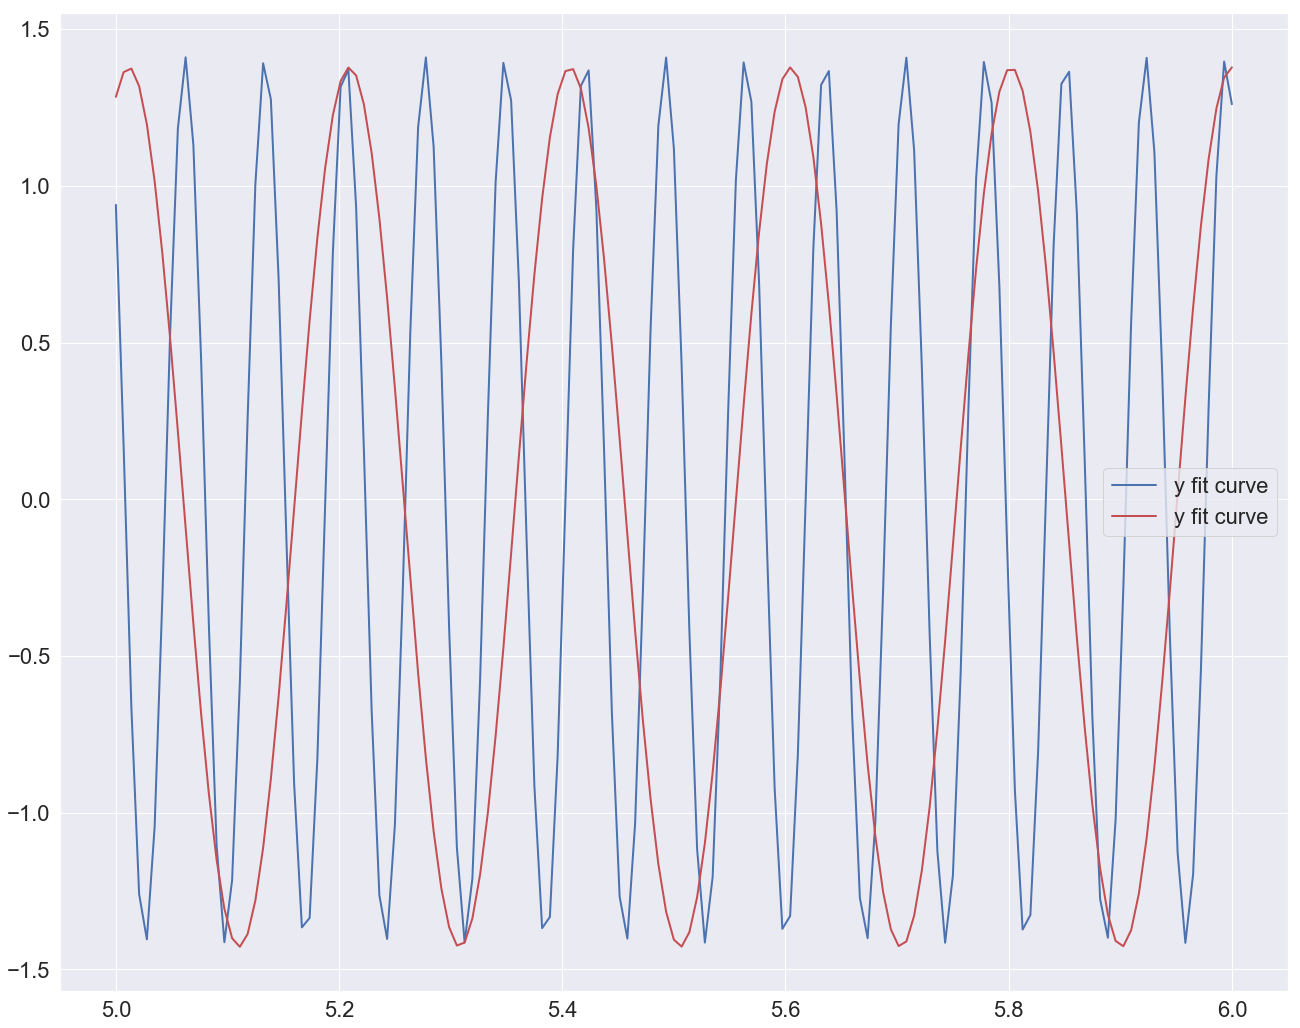

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426]


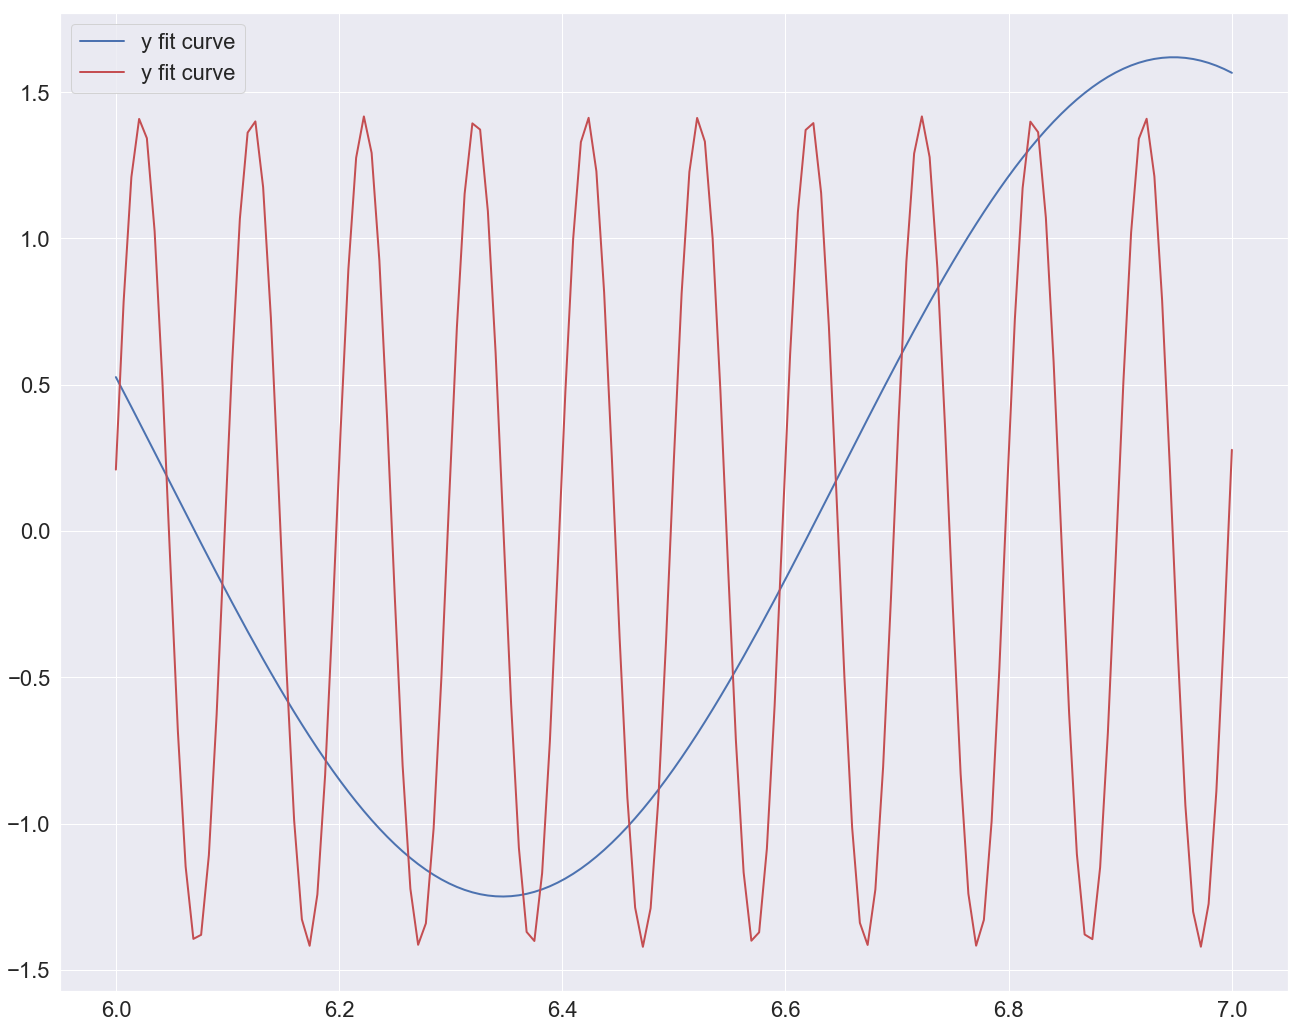

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987]


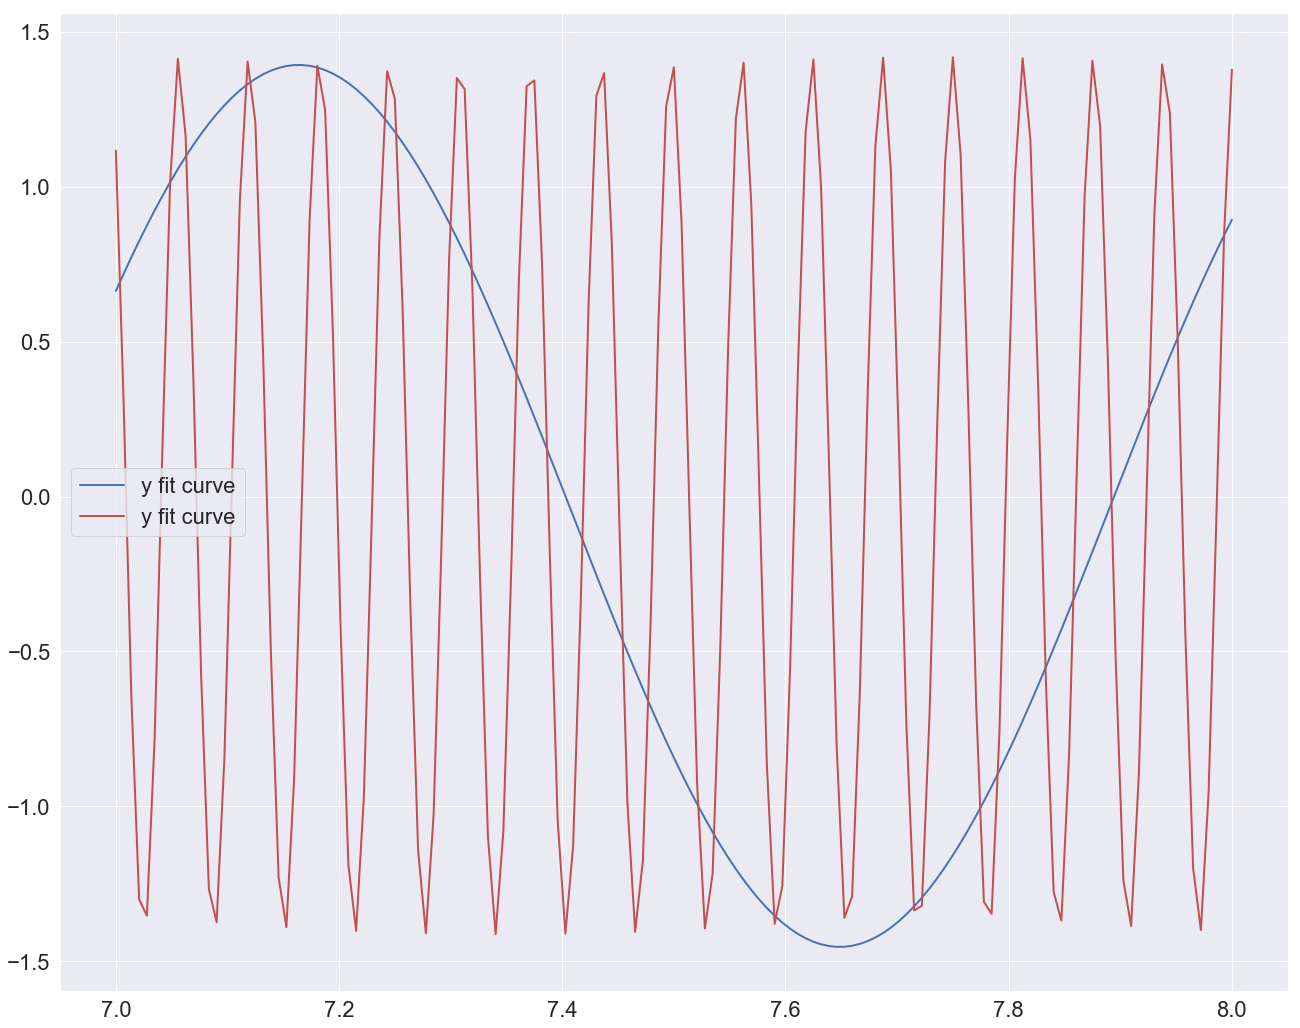

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418]


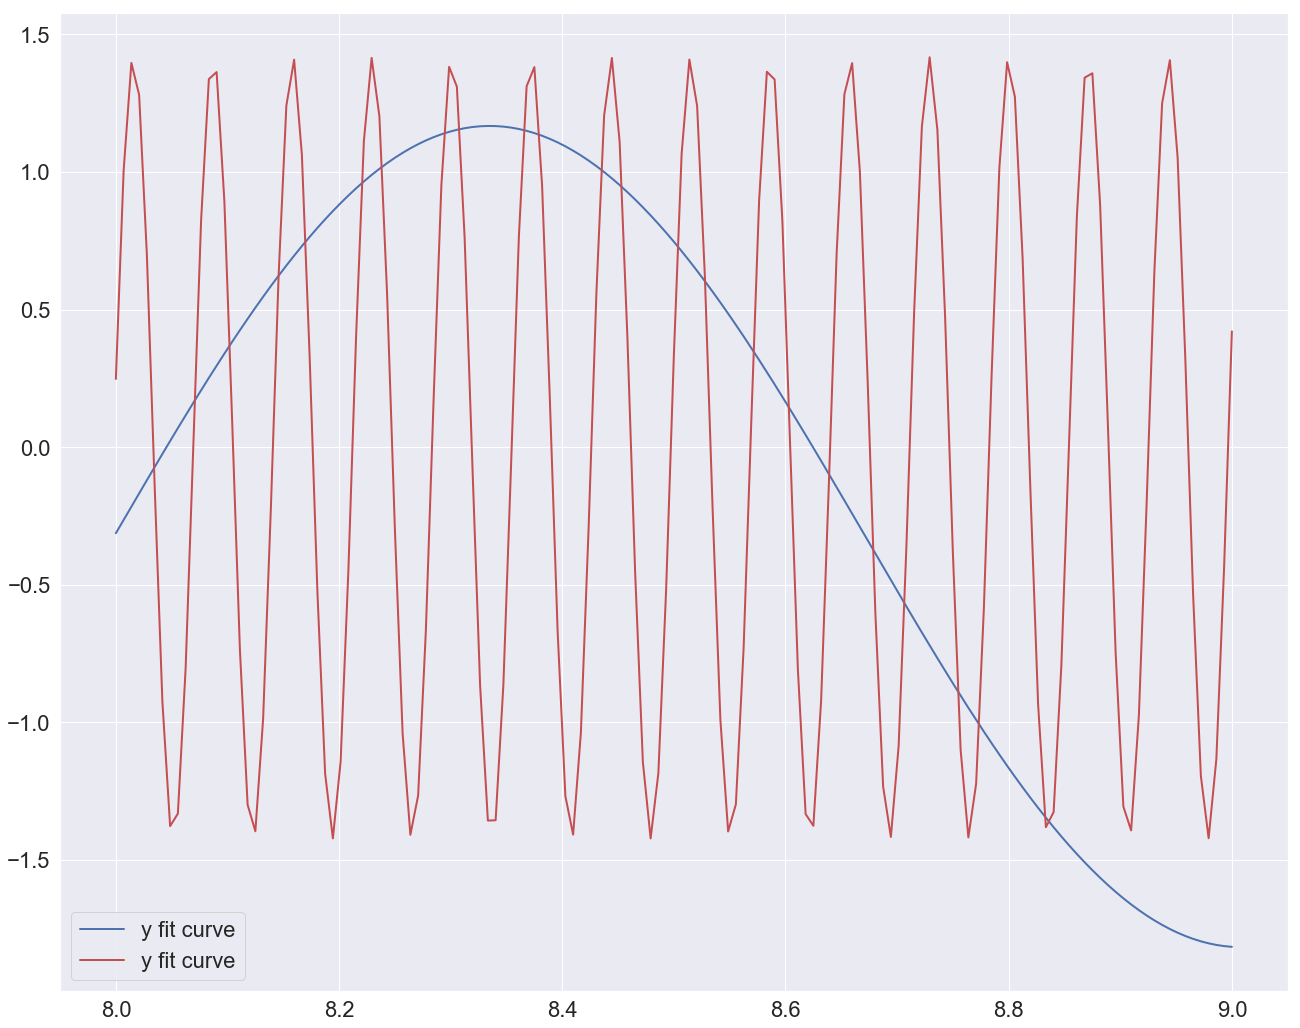

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179]


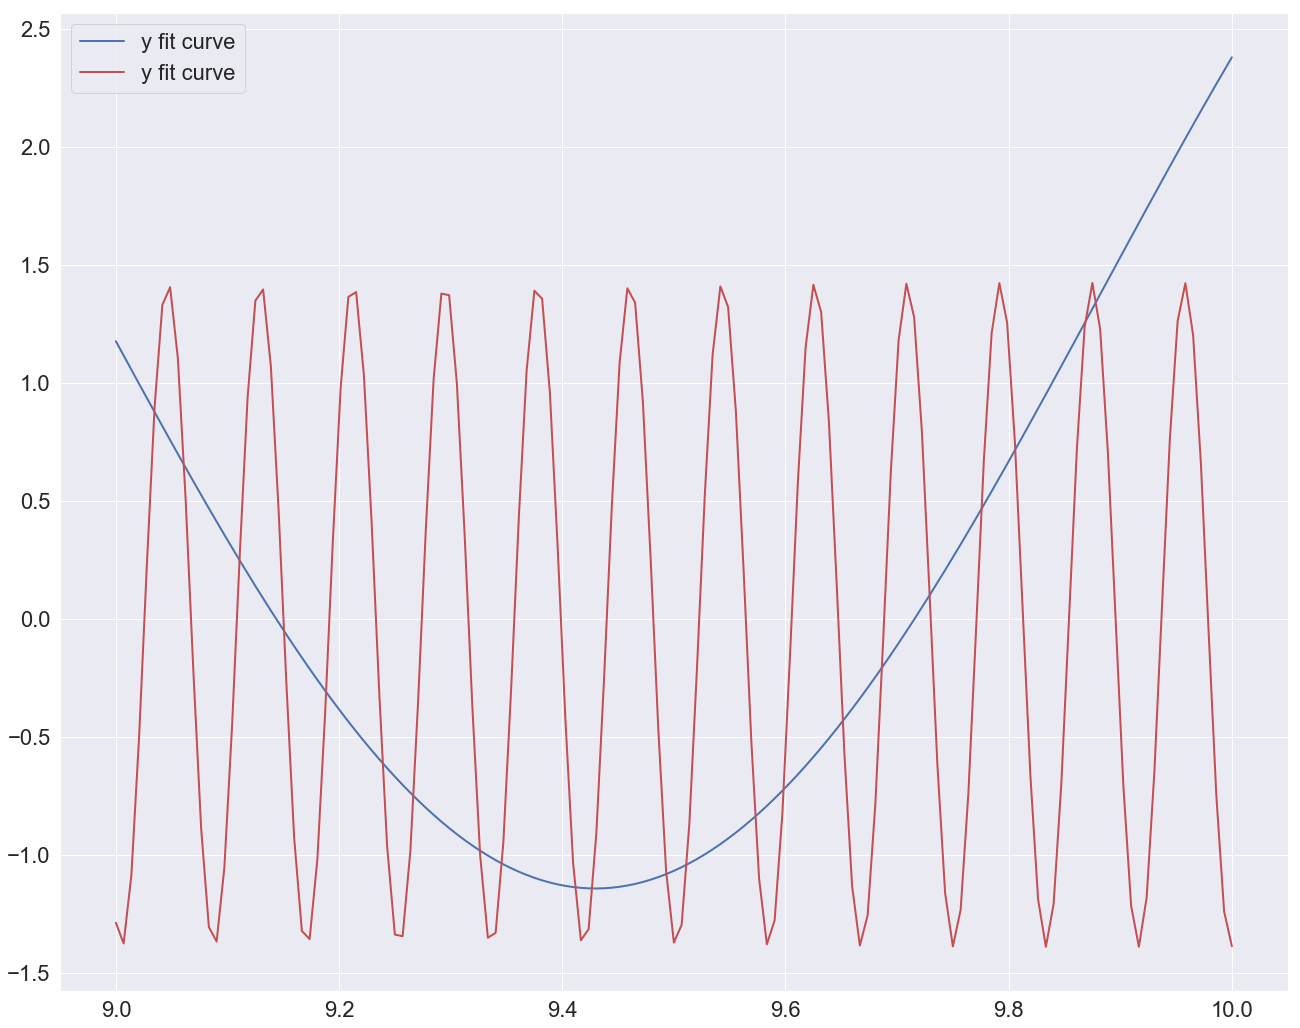

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033]


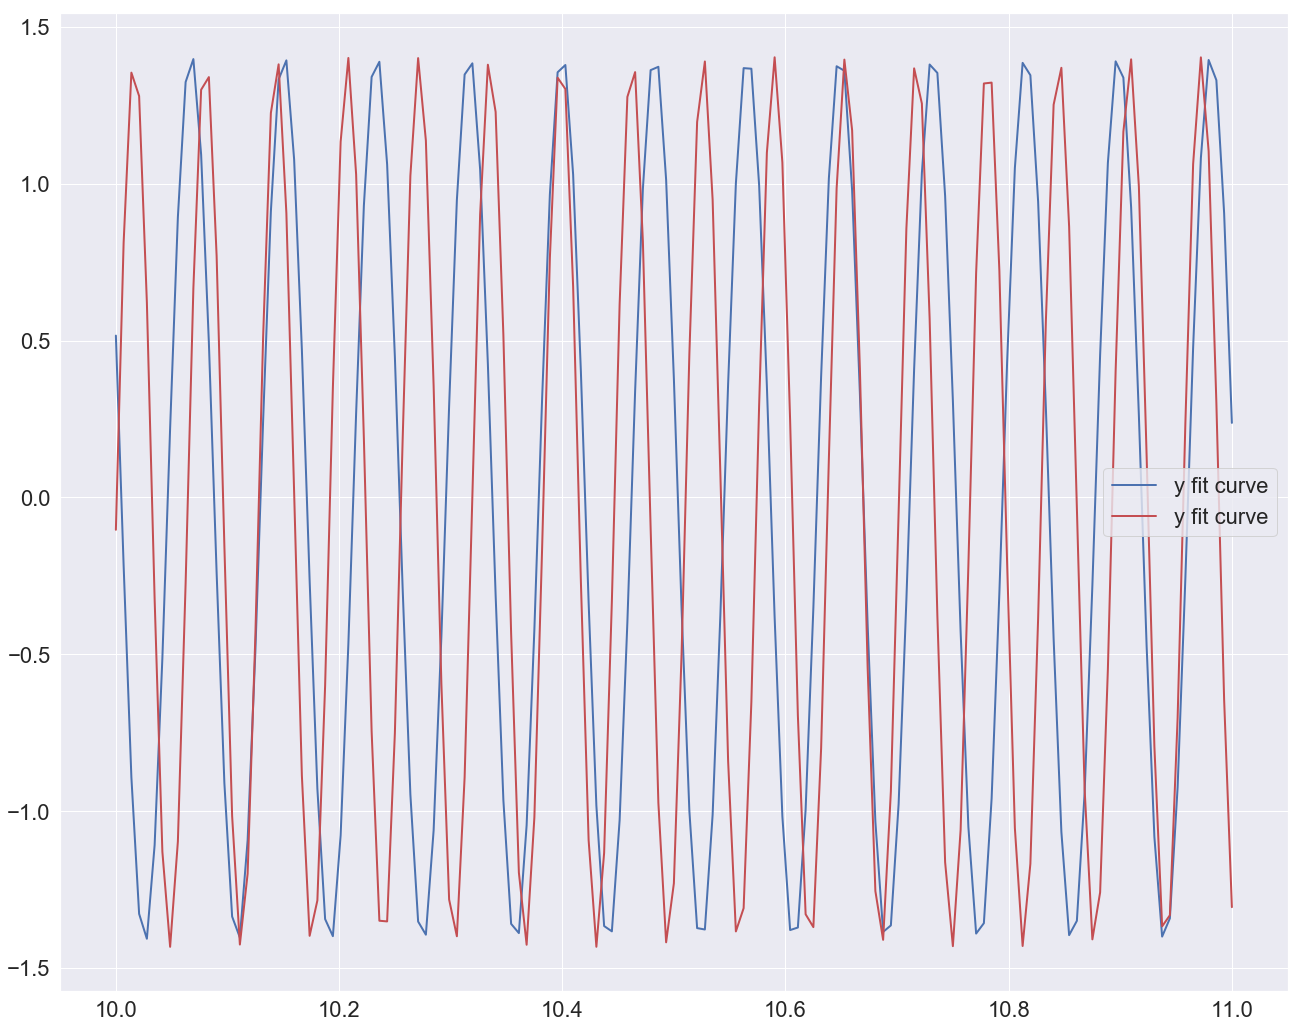

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145]


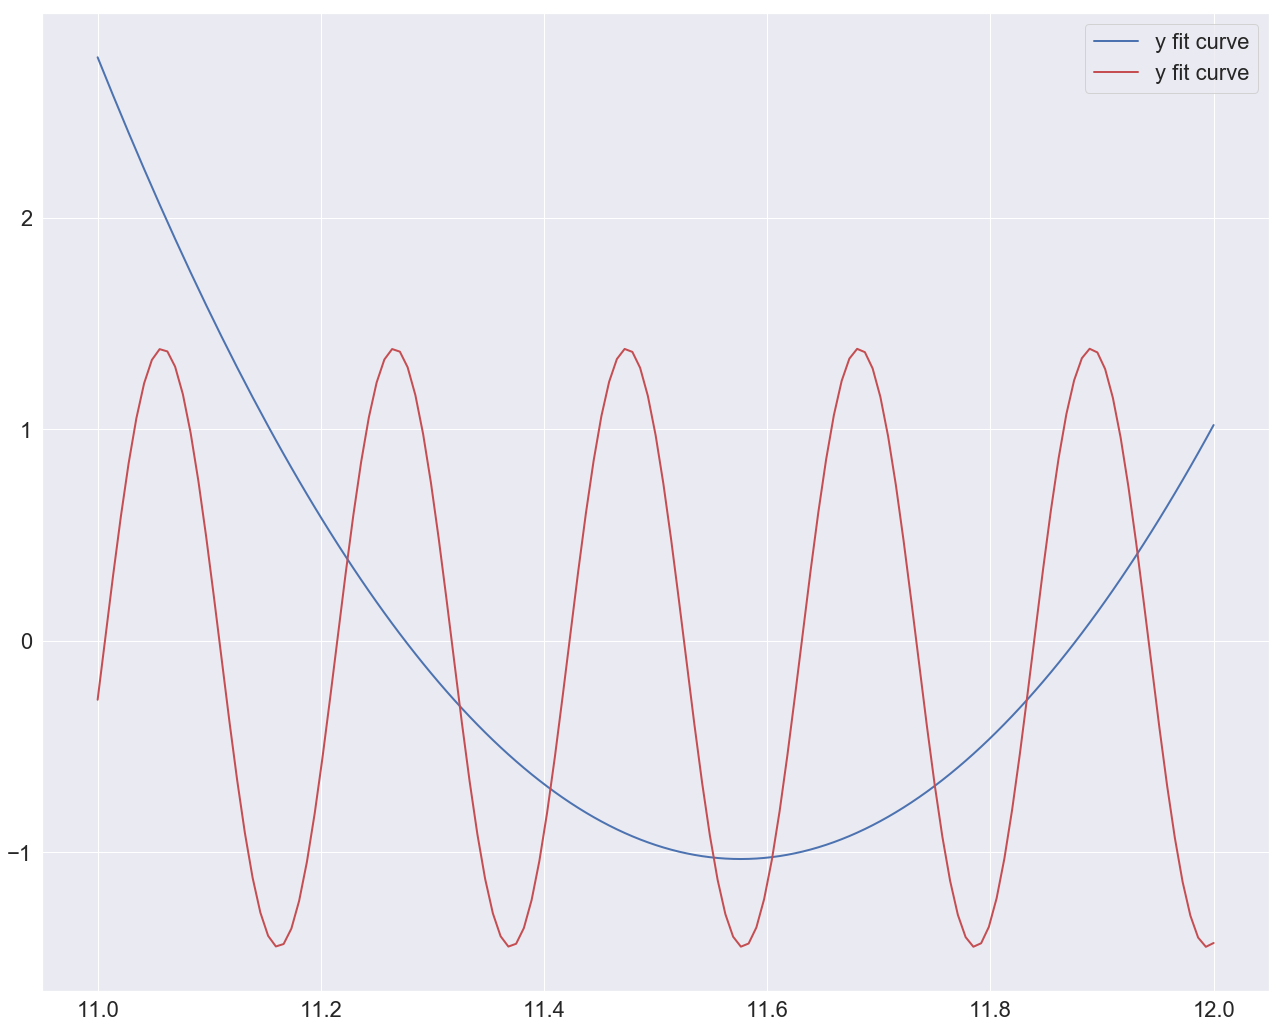

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987]


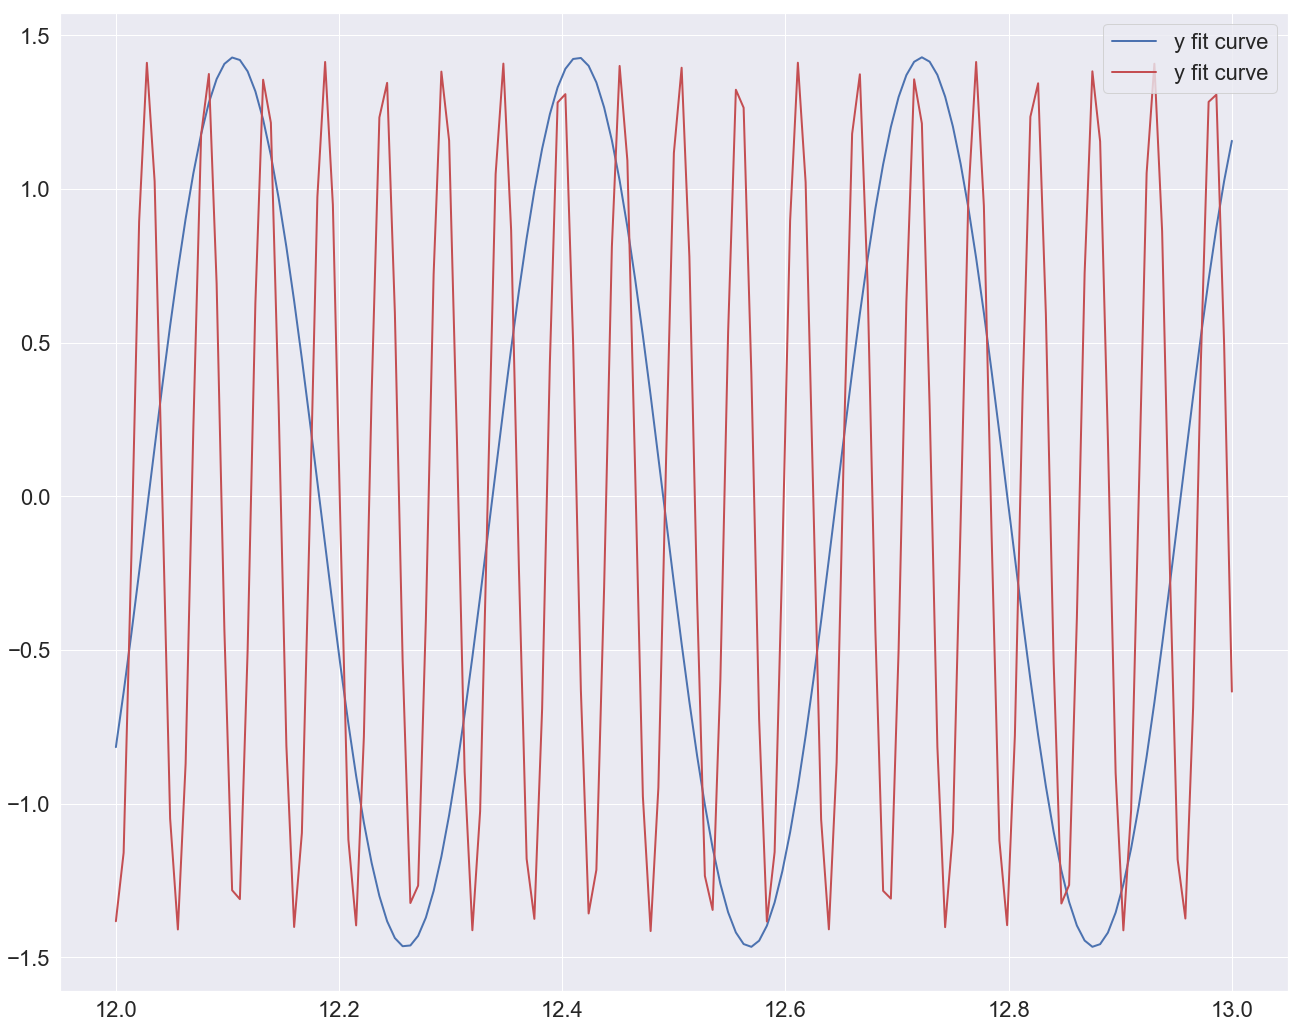

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987, 0.05089508511472716]


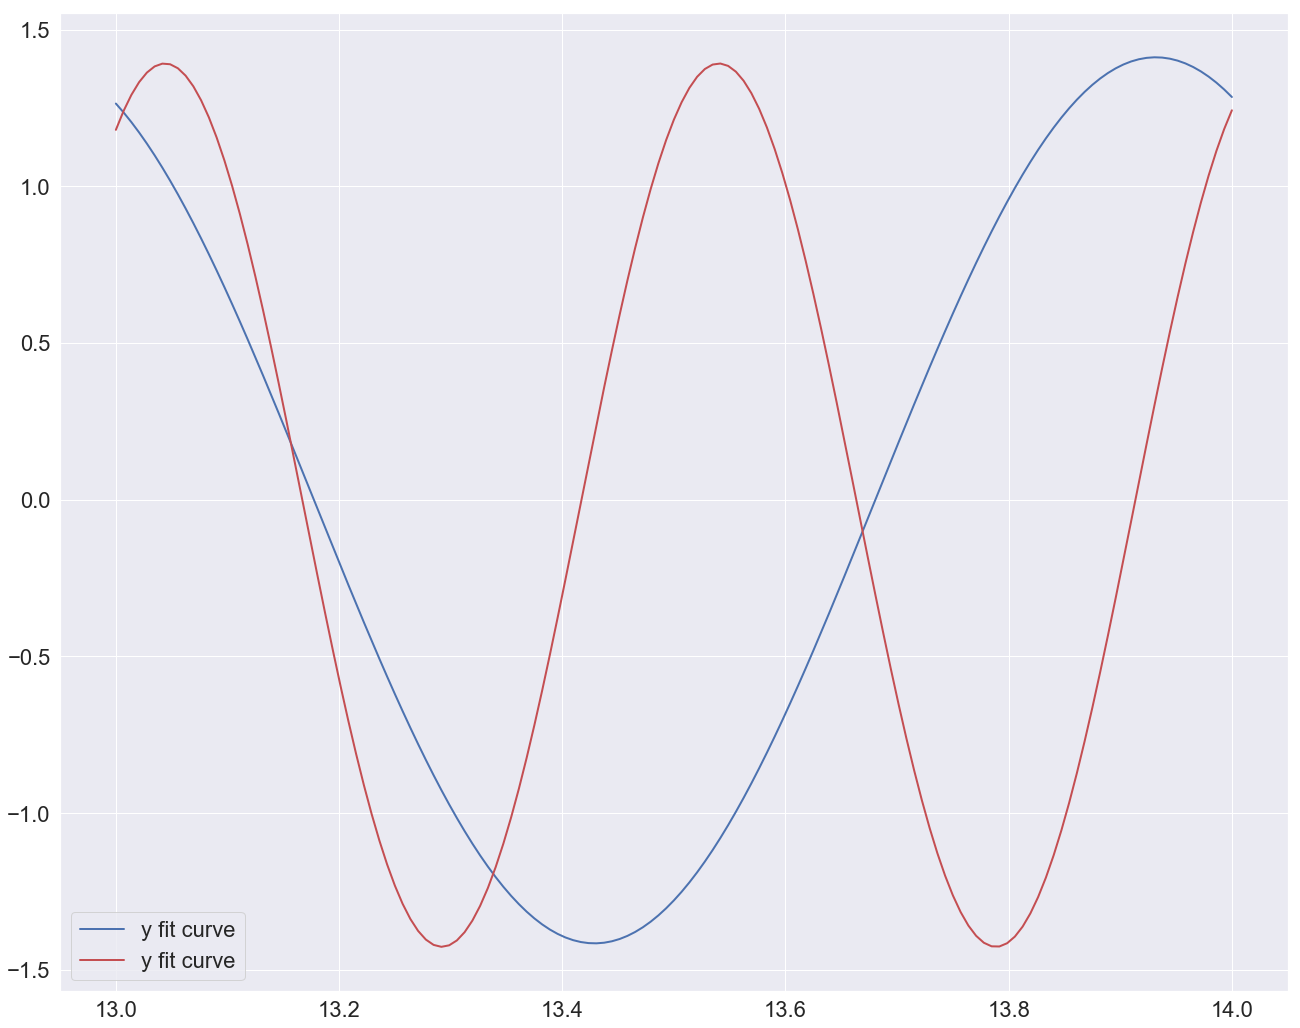

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987, 0.05089508511472716, 0.052383121269189384]


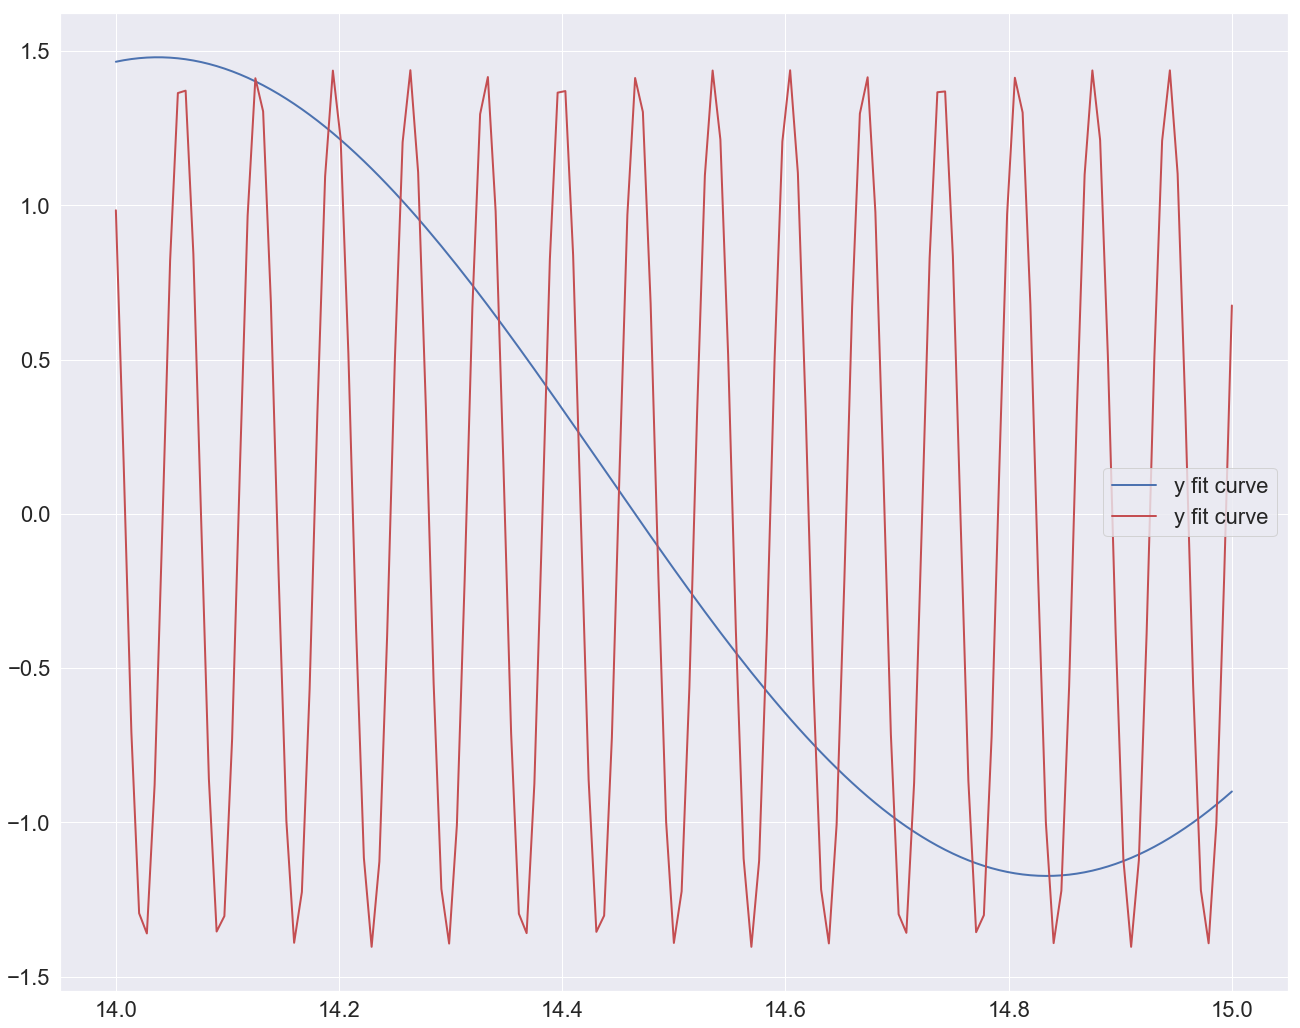

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987, 0.05089508511472716, 0.052383121269189384, 0.04777170112229899]


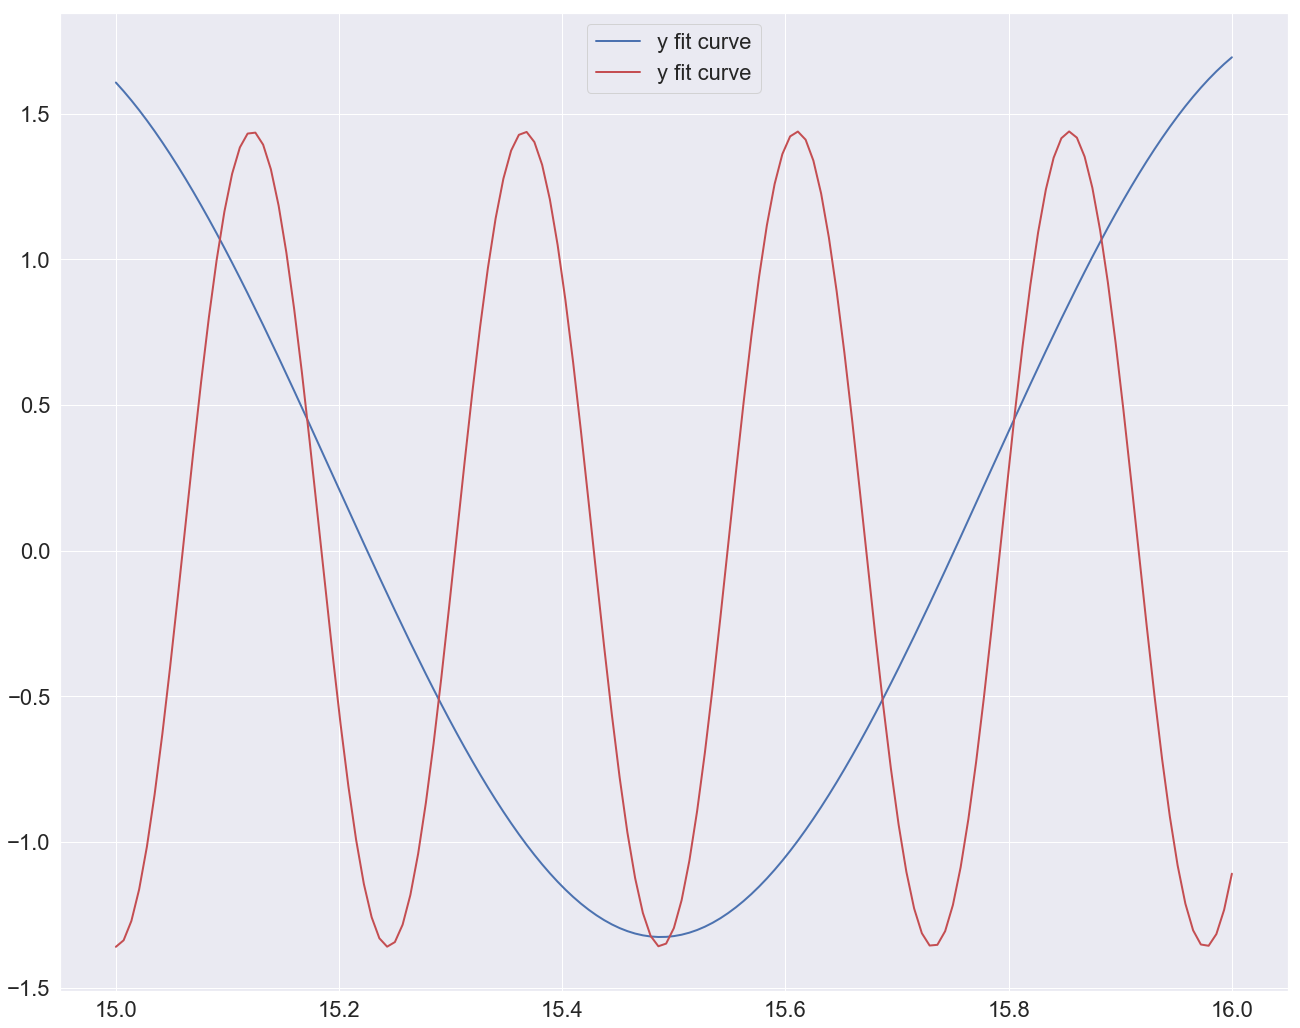

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987, 0.05089508511472716, 0.052383121269189384, 0.04777170112229899, 0.05648244666433978]


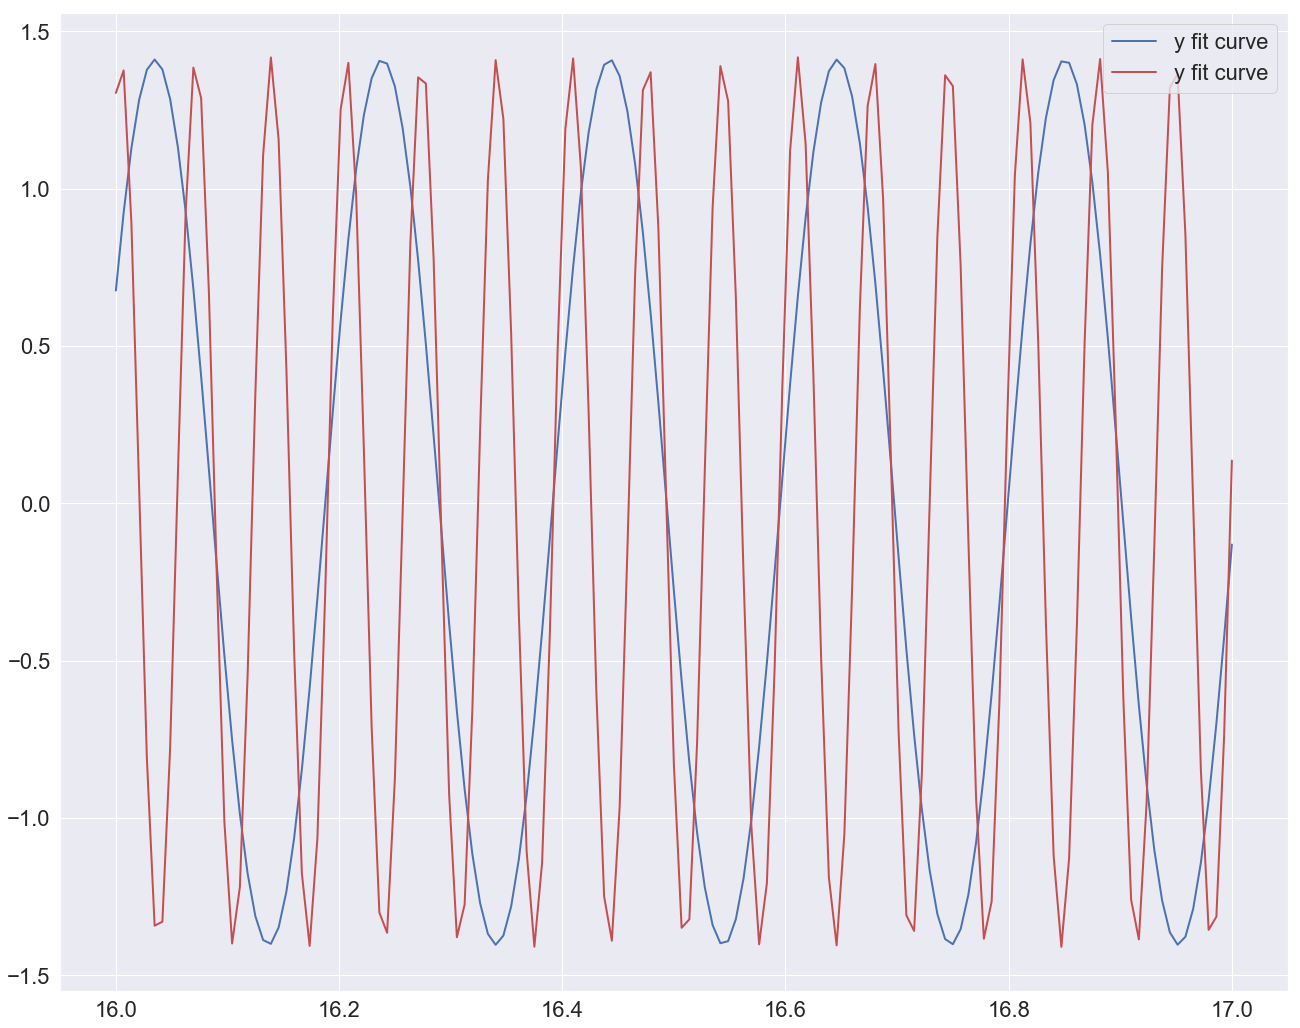

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987, 0.05089508511472716, 0.052383121269189384, 0.047771701122

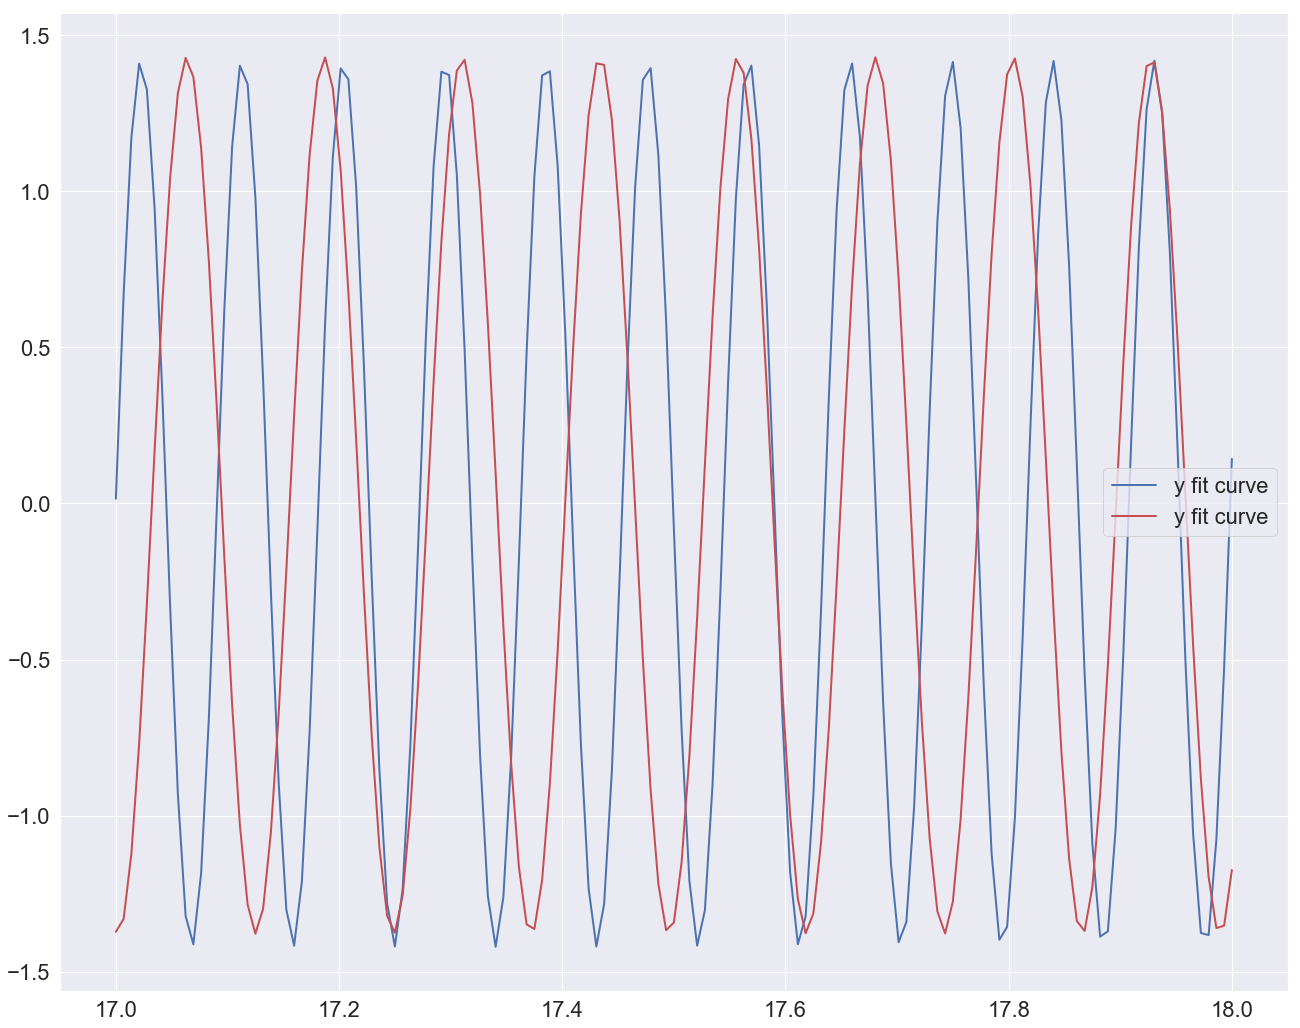

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.053739834370499145, 0.05777106262275987, 0.05089508511472

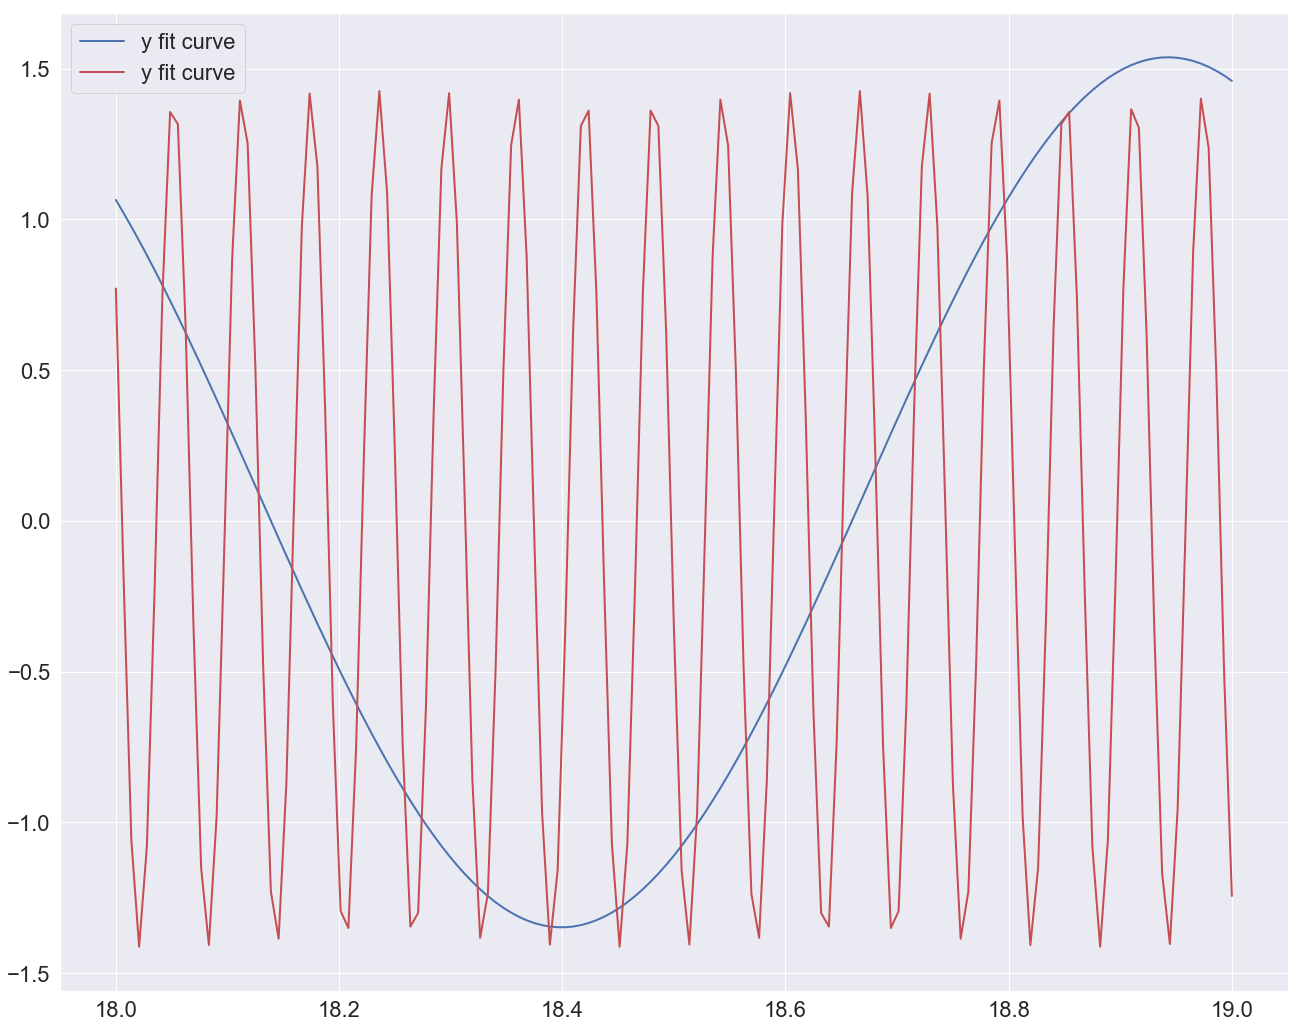

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.05095833649349179, 0.05279899263774033, 0.05373983437049914

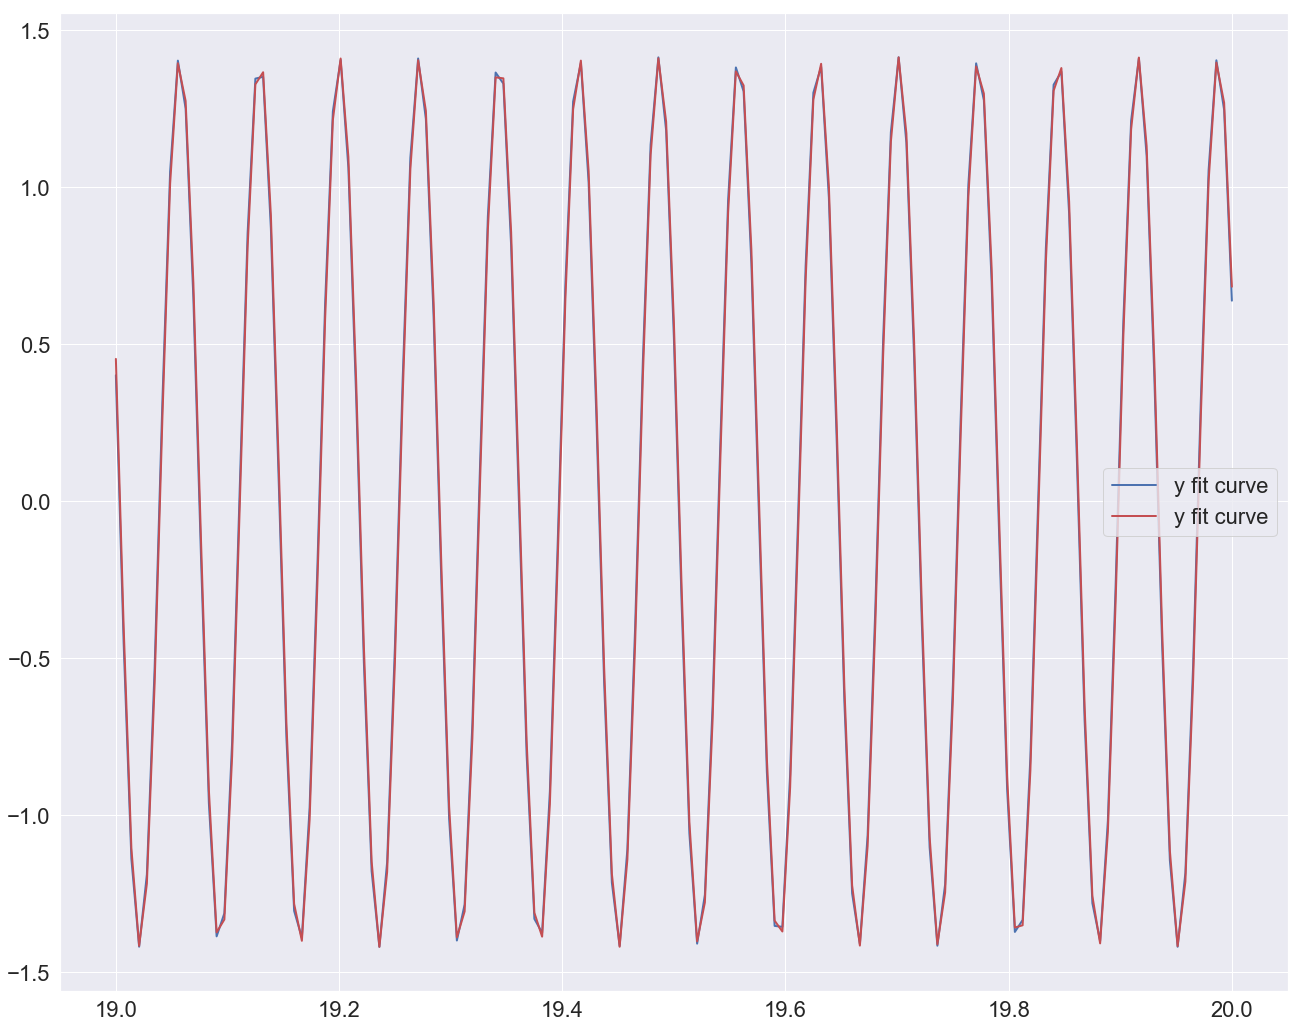

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987, 0.04425130564571418, 0.050958336493491

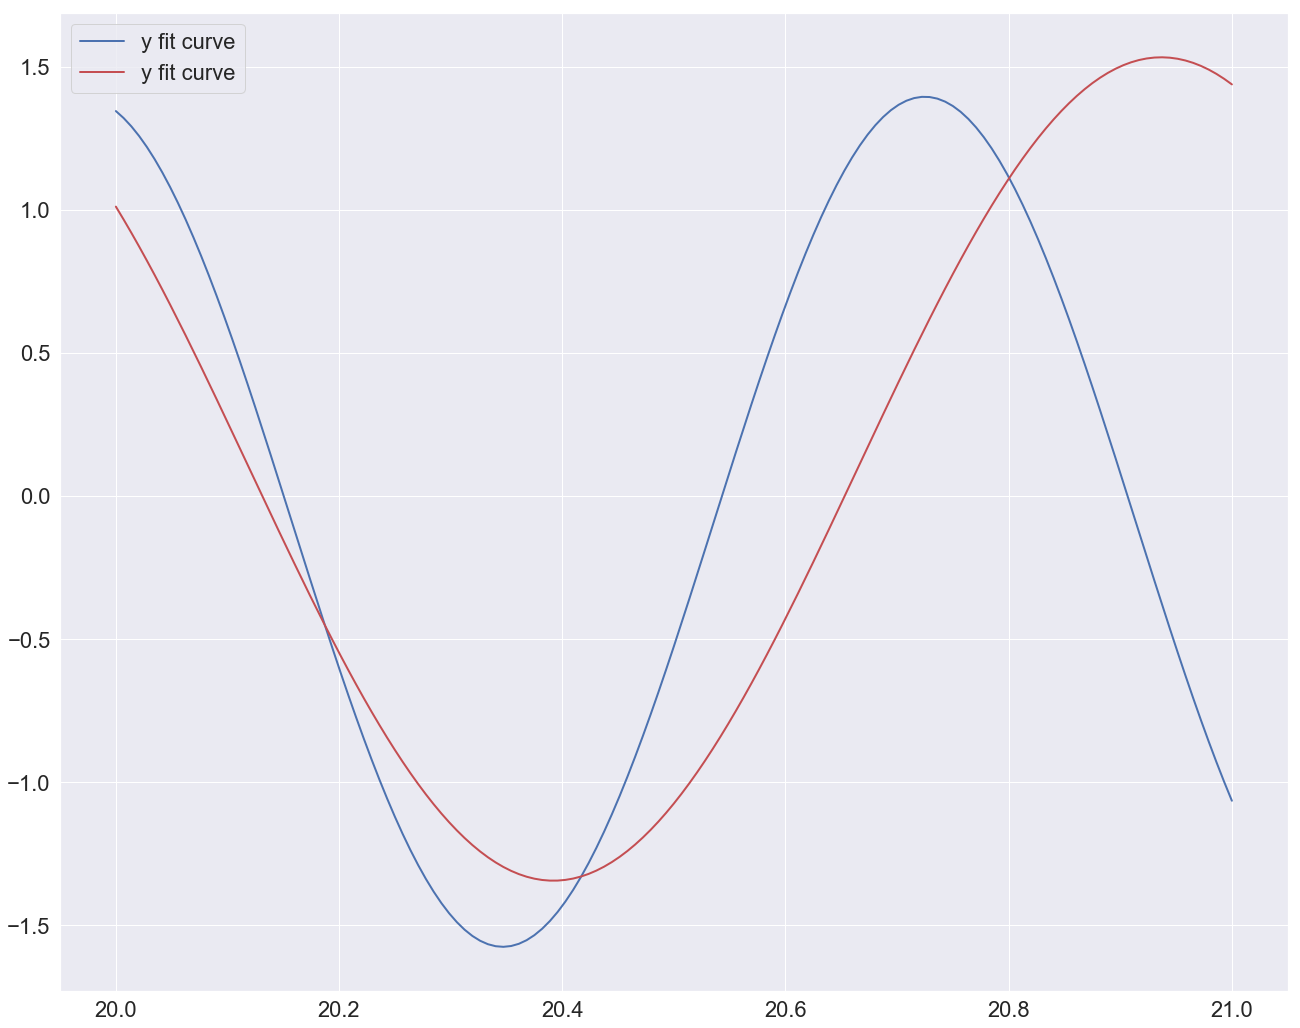

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775, 0.04879699149414426, 0.04901756309228987

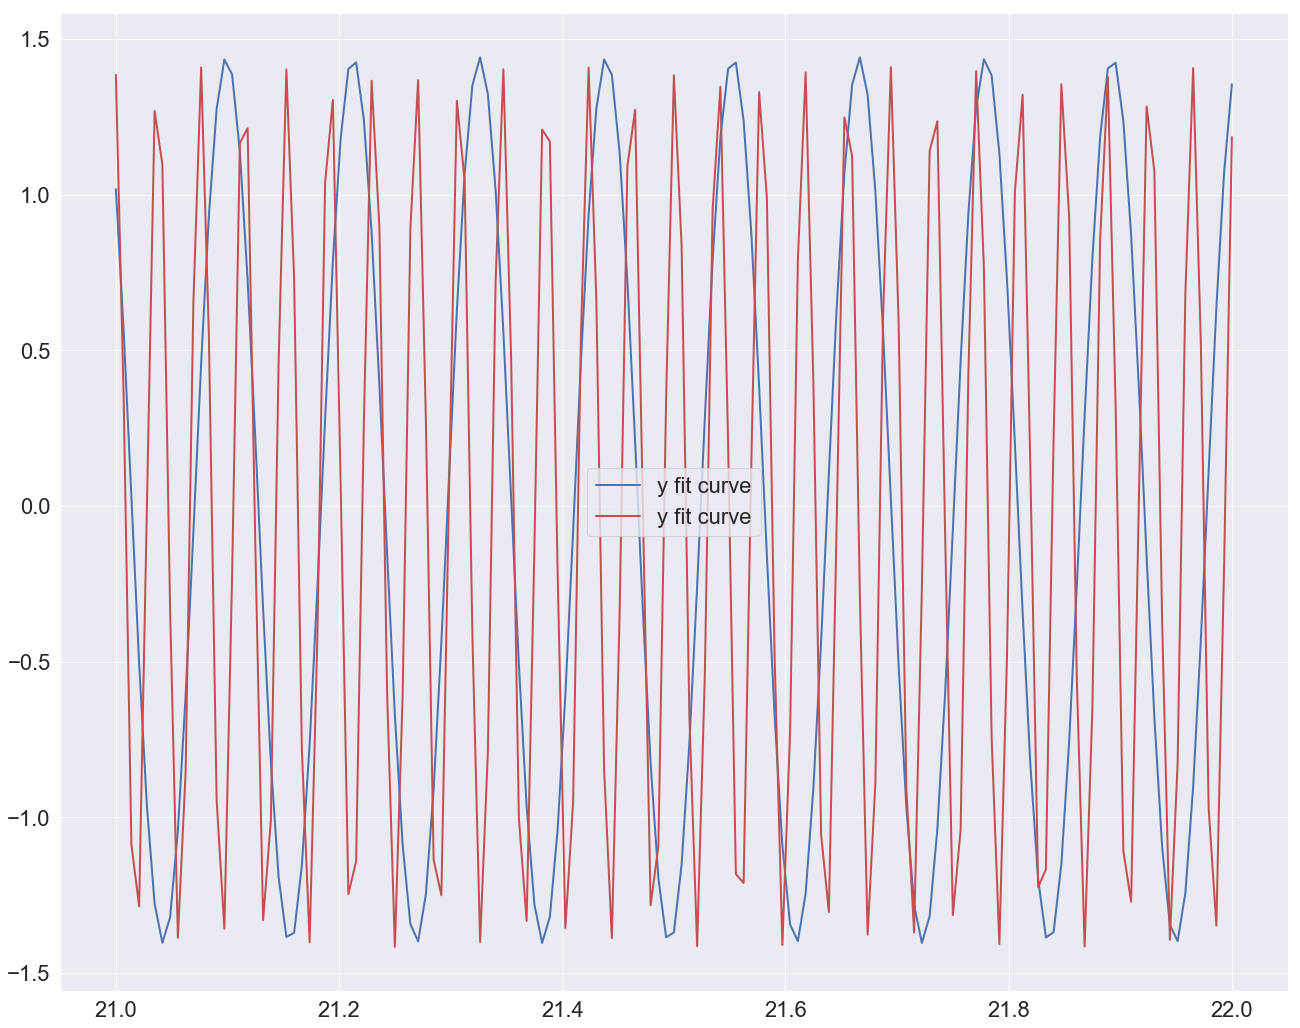

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.0864019837372]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.03625707601687039, 0.04094923694478775,

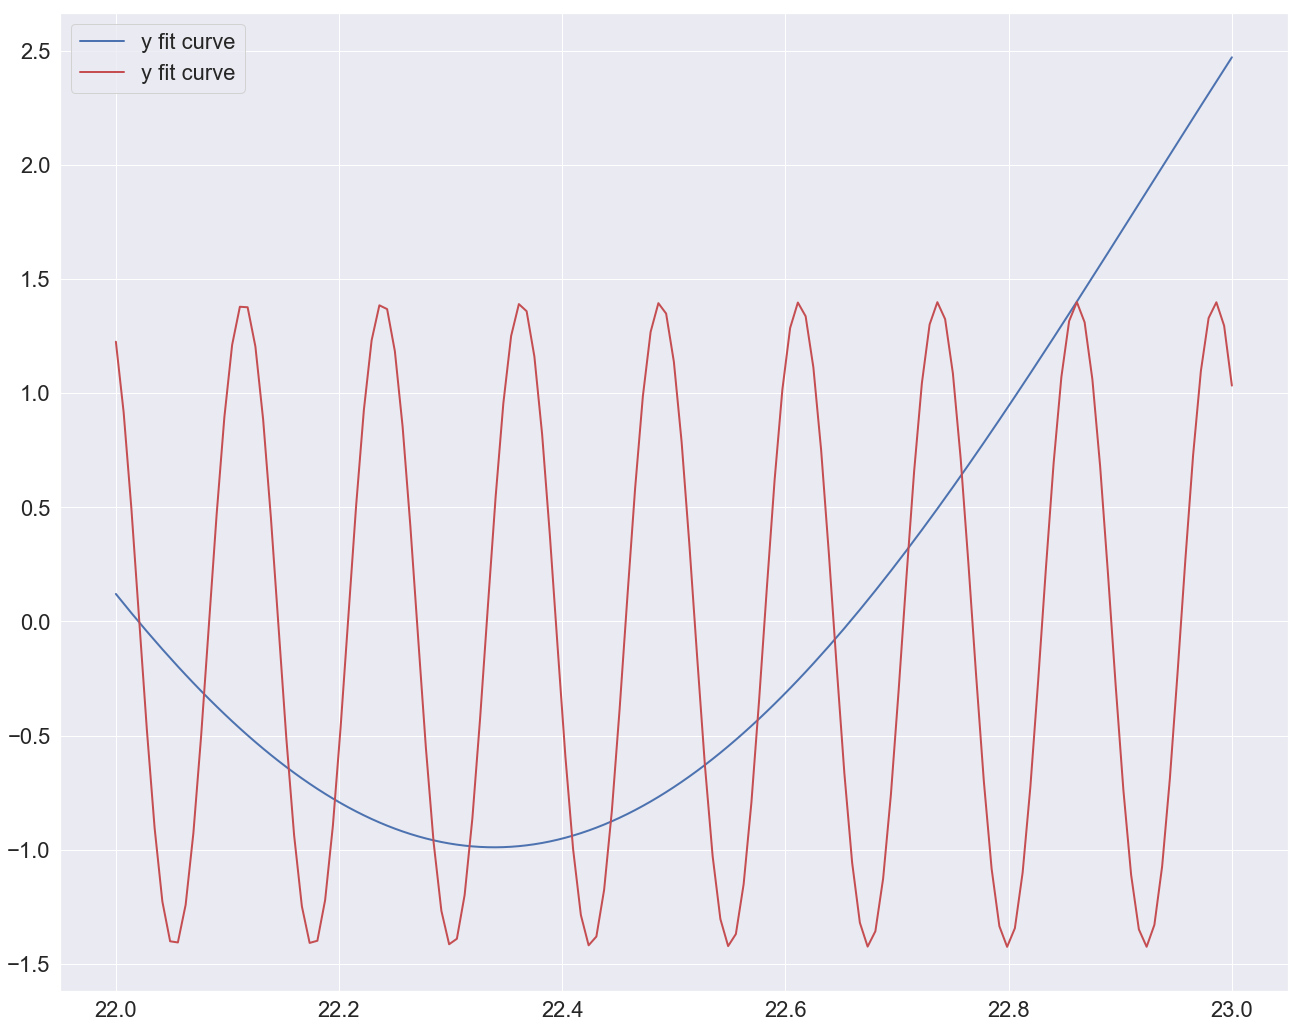

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.0864019837372, -1345.8117264190157]
[0.04928357751234016, 0.028227941794938132, 0.03848257574598751, 0.

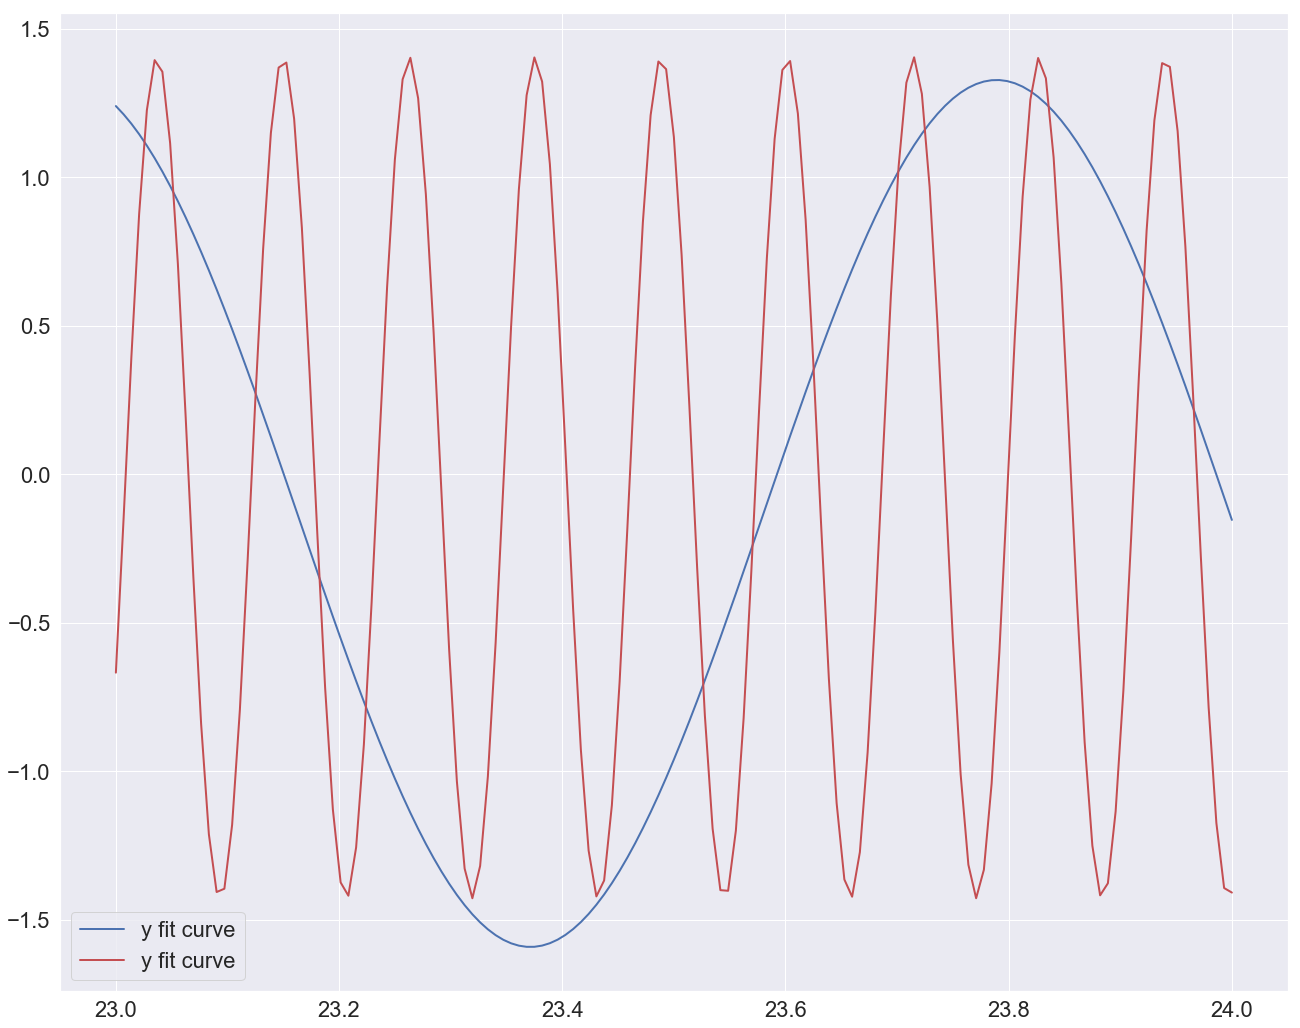

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.0864019837372, -1345.8117264190157, -1363.2153128293178]
[0.04928357751234016, 0.02

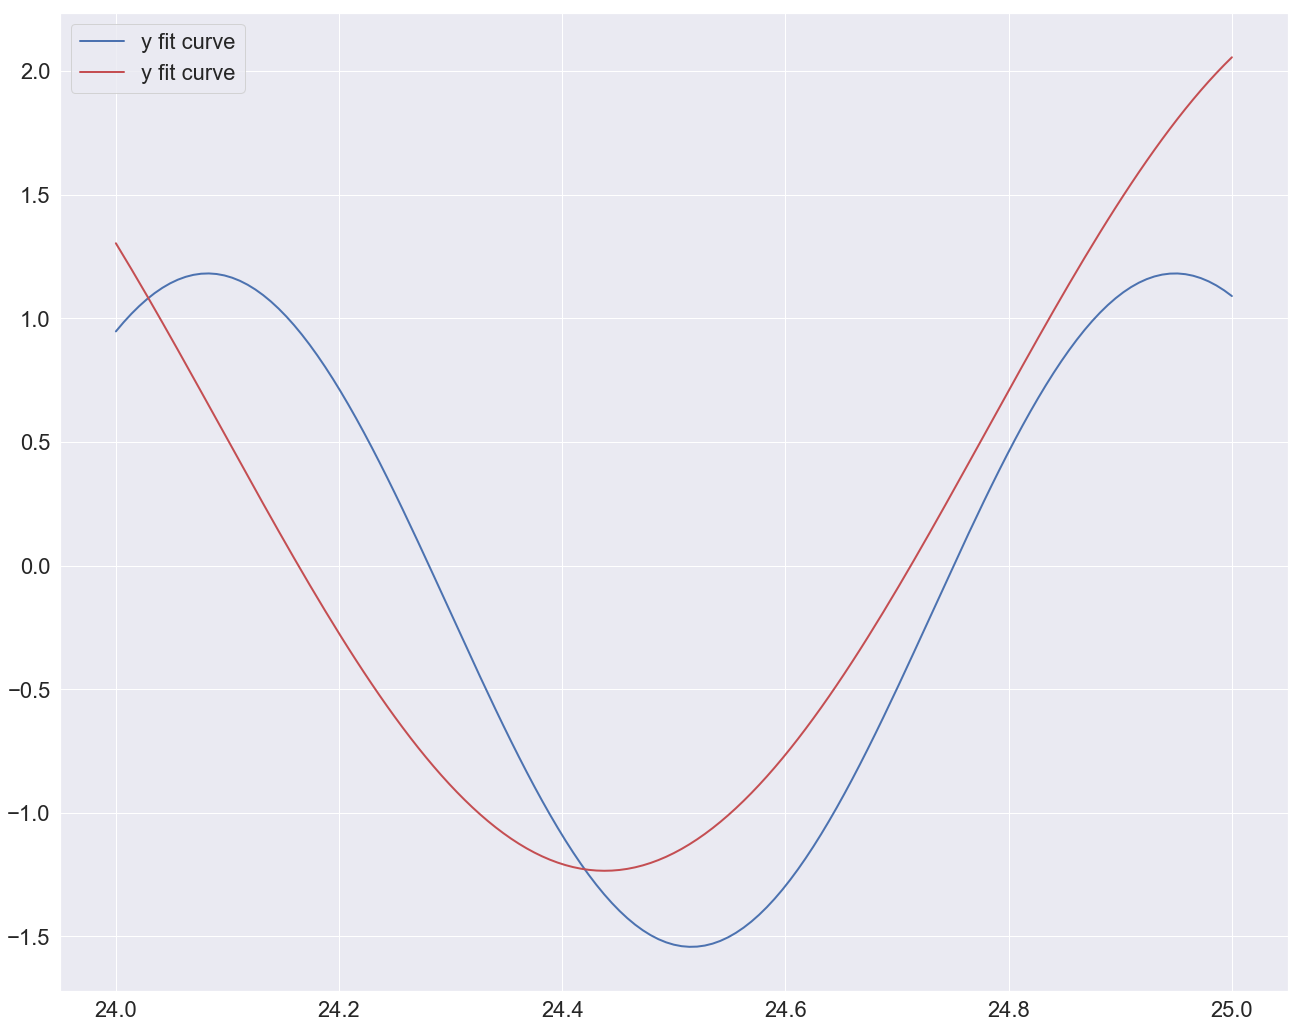

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.0864019837372, -1345.8117264190157, -1363.2153128293178, -1350.5

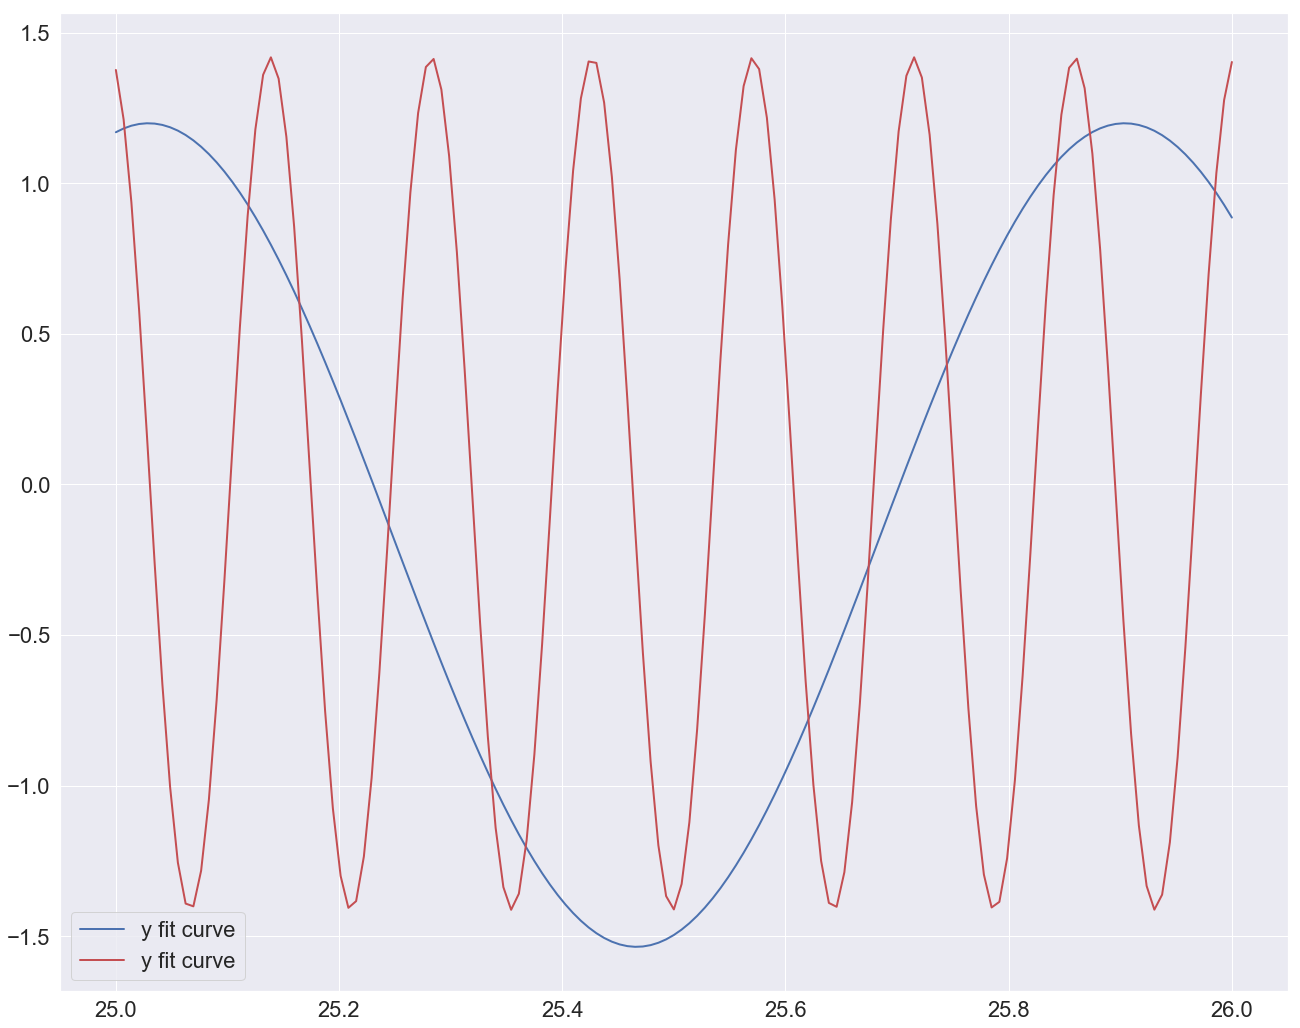

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629, 2.0202706458141164]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.0864019837372, -1345.8117264190157, -1363.21

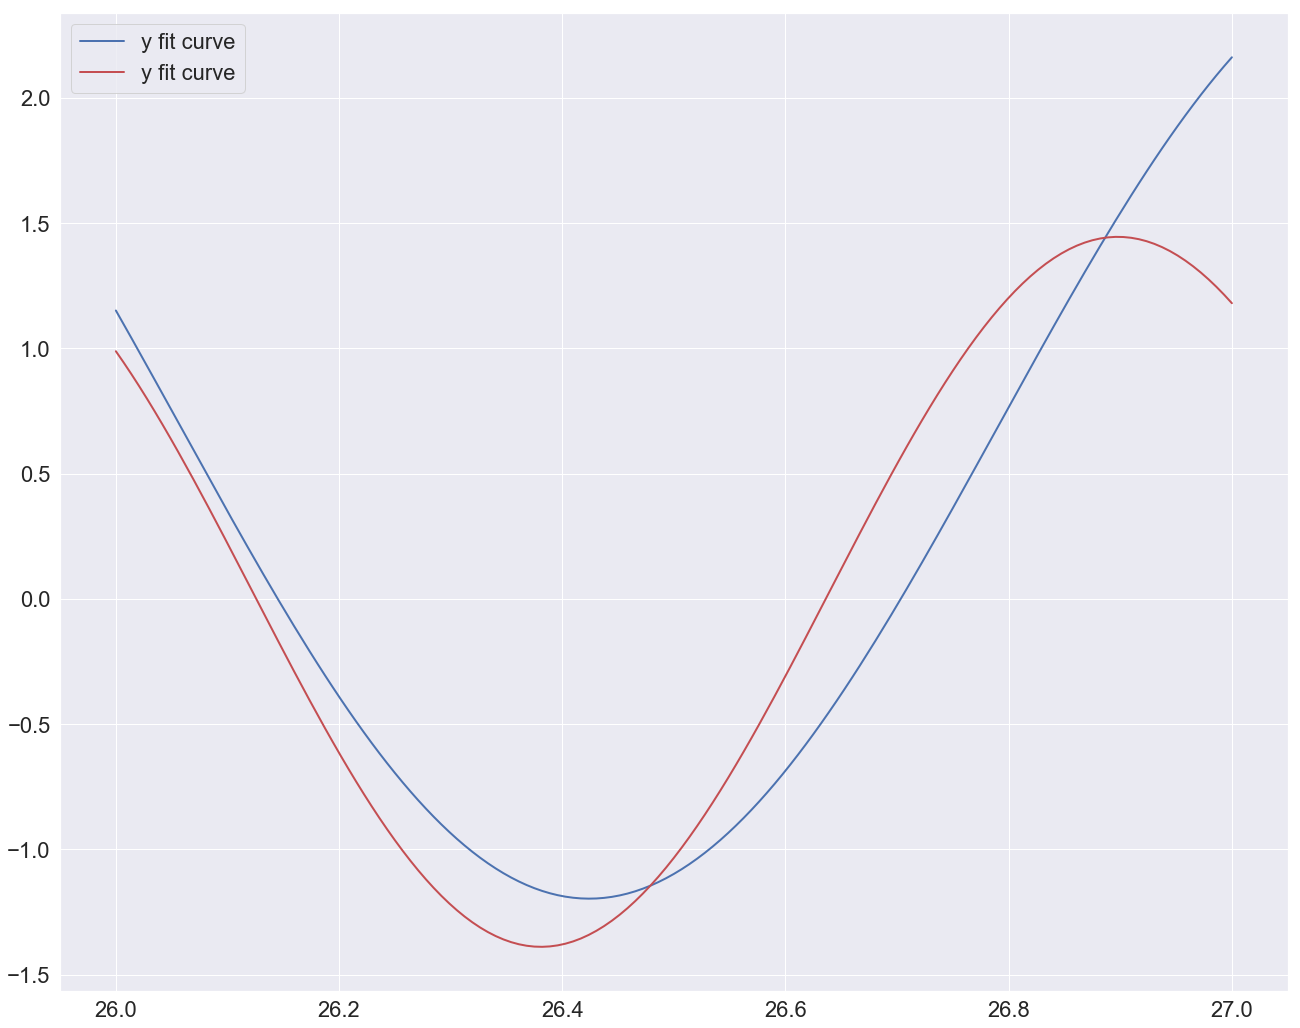

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629, 2.0202706458141164, 0.12047051247008389]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.0864019837372, -1345.81

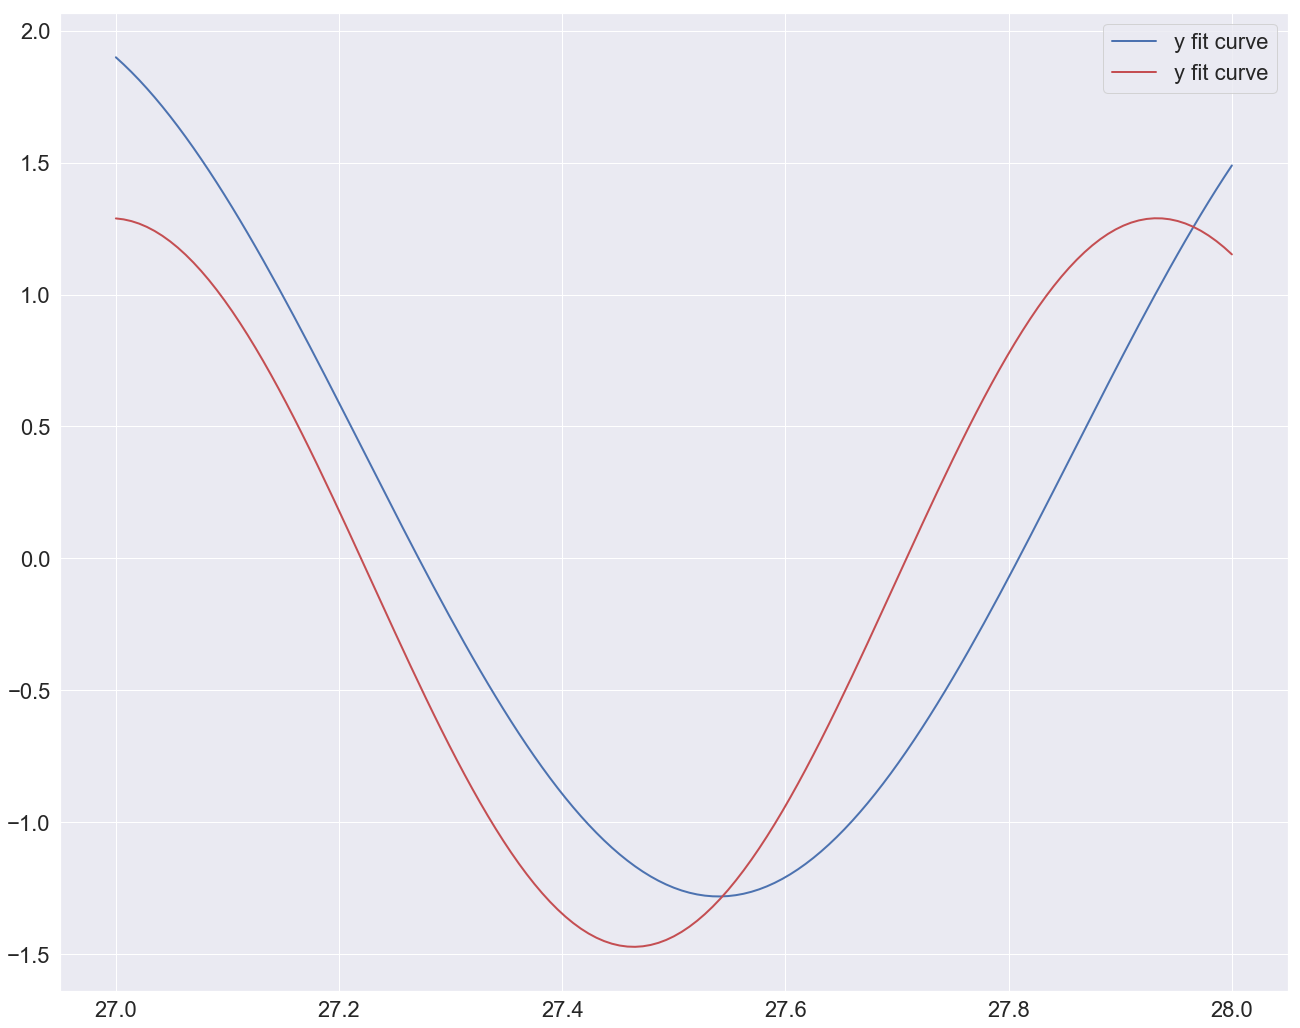

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629, 2.0202706458141164, 0.12047051247008389, 0.2502690215699235]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438547895028, -1353.086

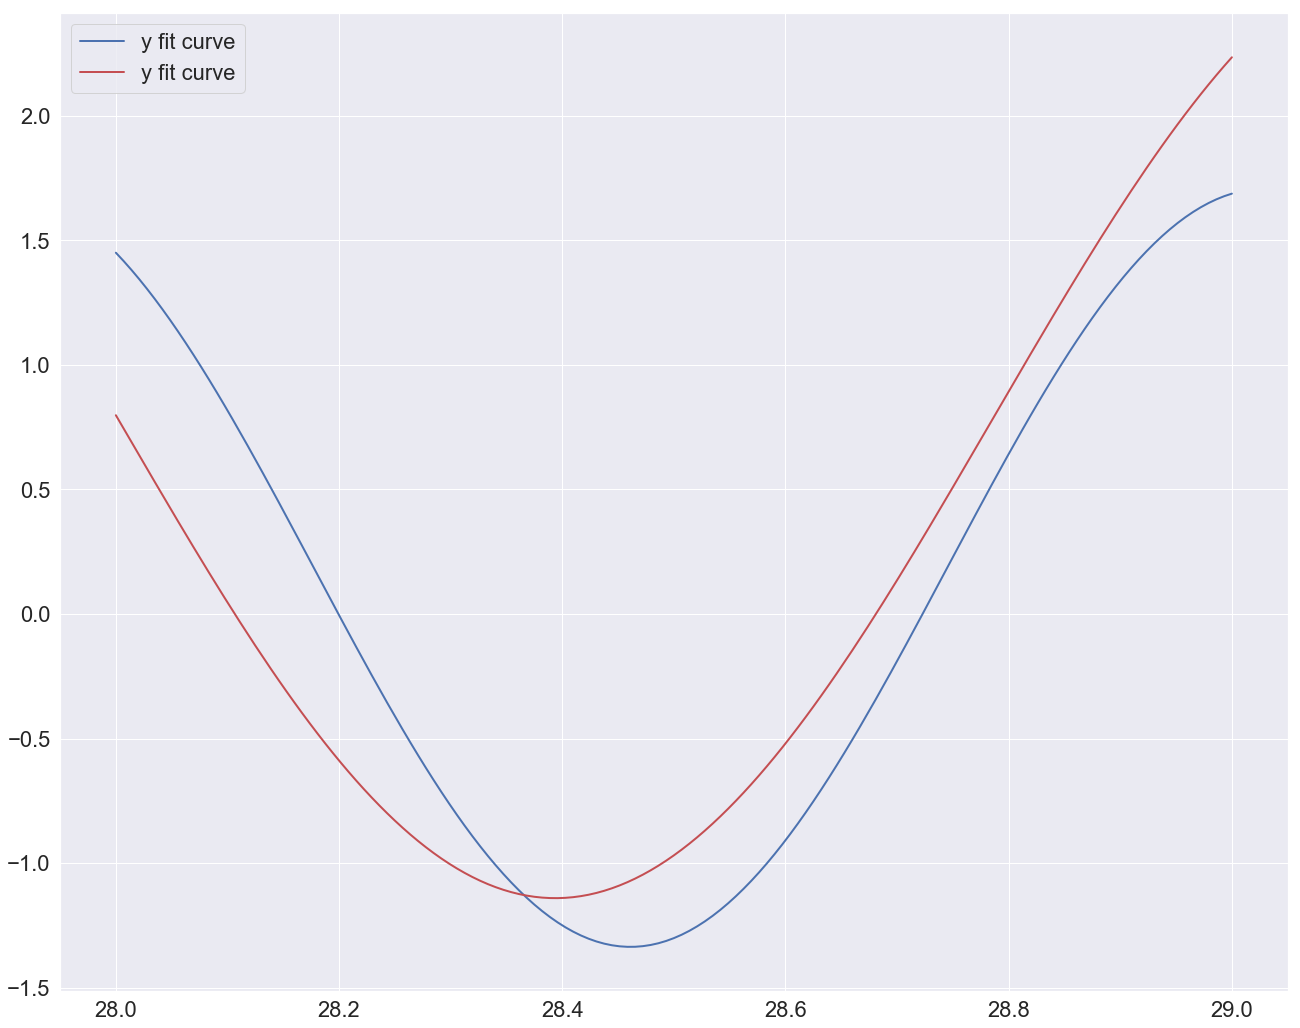

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629, 2.0202706458141164, 0.12047051247008389, 0.2502690215699235, 0.1894099876105527]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773890277753, -1370.8438

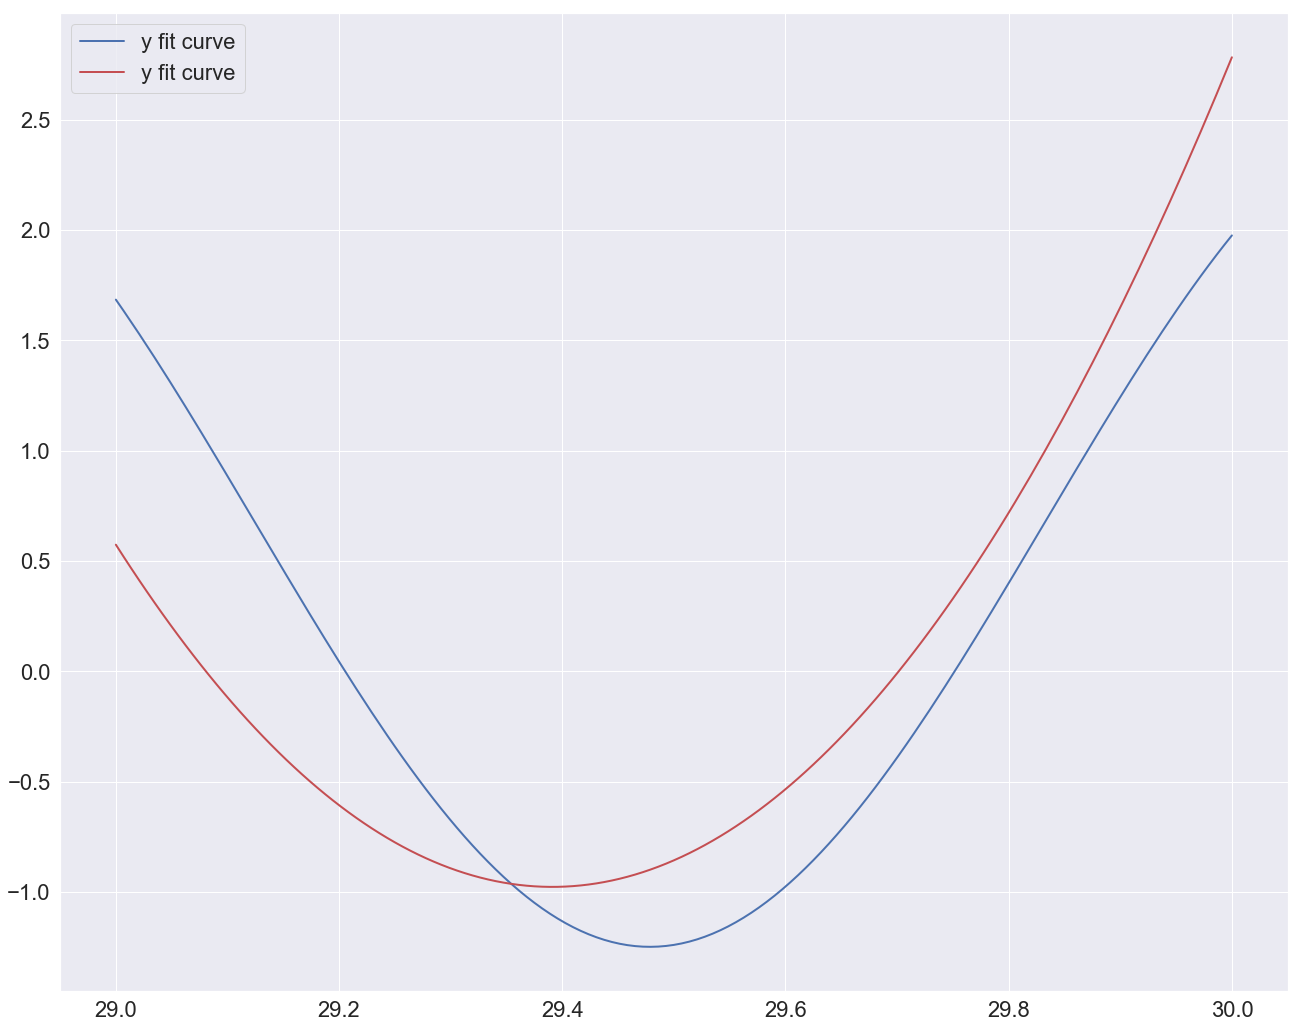

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629, 2.0202706458141164, 0.12047051247008389, 0.2502690215699235, 0.1894099876105527, 0.31765137536377747]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.9171874586411, -1358.5773

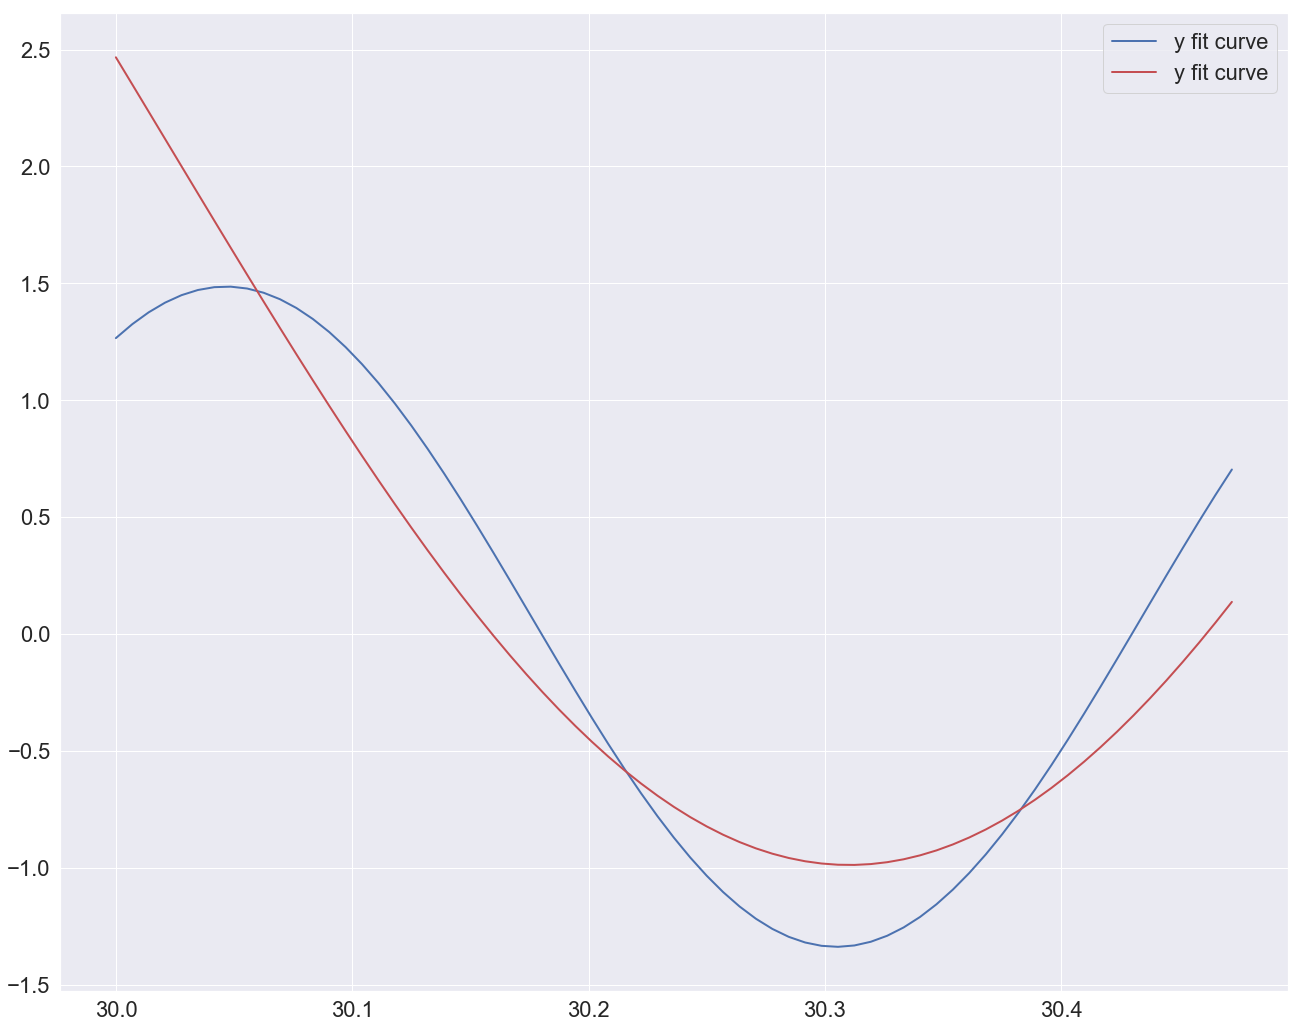

[2.2122961224657924, 2.045211161733851, 2.044516113200298, 1.9658969481896895, 2.011504173300827, 1.9965739427050384, 2.0408190054142454, 2.003169295694455, 1.9620303636307255, 2.062758351337877, 1.8960345476396512, 1.8166006967843835, 1.9658729119048444, 1.9502369391125187, 2.0021898103905045, 2.166909889478625, 1.9926963636876316, 2.0143272464418556, 2.010844714694202, 0.0014017052105995225, 0.779740015682007, 1.9850720552859367, 1.88073266632867, 1.9383261792057467, 0.305016379675629, 2.0202706458141164, 0.12047051247008389, 0.2502690215699235, 0.1894099876105527, 0.31765137536377747, 0.1431221733833498]
[-1342.2110424576656, -1332.5050455622188, -1338.730796048355, -1336.8756546527563, -1355.0699947571504, -1351.7960753502912, -1364.2641240798025, -1361.252550073256, -1384.9484779437585, -1356.220659268813, -1361.031999642211, -1364.2072213372255, -1355.7196933878743, -1353.5622070934787, -1363.8280405042517, -1358.3613626998413, -1356.742309144342, -1356.8003221569015, -1364.91718

In [404]:
step = 6*24
s = 0
e = step
result = []
er1 = []
er2 = []

for i in np.arange(data.shape[0]/step):
    
    temperature = data.loc[s:e, "T"]
    acceleration = data.loc[s:e, "dG"]
    x = time_array[s:e+1]
    
    res1 = fit_sin(x, temperature)
    res2 = fit_sin(x, acceleration)
    
    plt.plot(x, stand(res1["fitfunc"](x)), "b-", label="y fit curve", linewidth=2)
    plt.plot(x, stand(res2["fitfunc"](x)), "r-", label="y fit curve", linewidth=2)
    plt.legend(loc="best")
    plt.show()
    
    result.append(mean((stand(res1["fitfunc"](x)) - stand(res2["fitfunc"](x)))**2))
    er1.append(mean((temperature) - (res1["fitfunc"](x))**2))
    er2.append(mean((acceleration) - (res2["fitfunc"](x))**2))
    print(result)
    print(er1)
    print(er2)
    
    
    s += step
    e += step

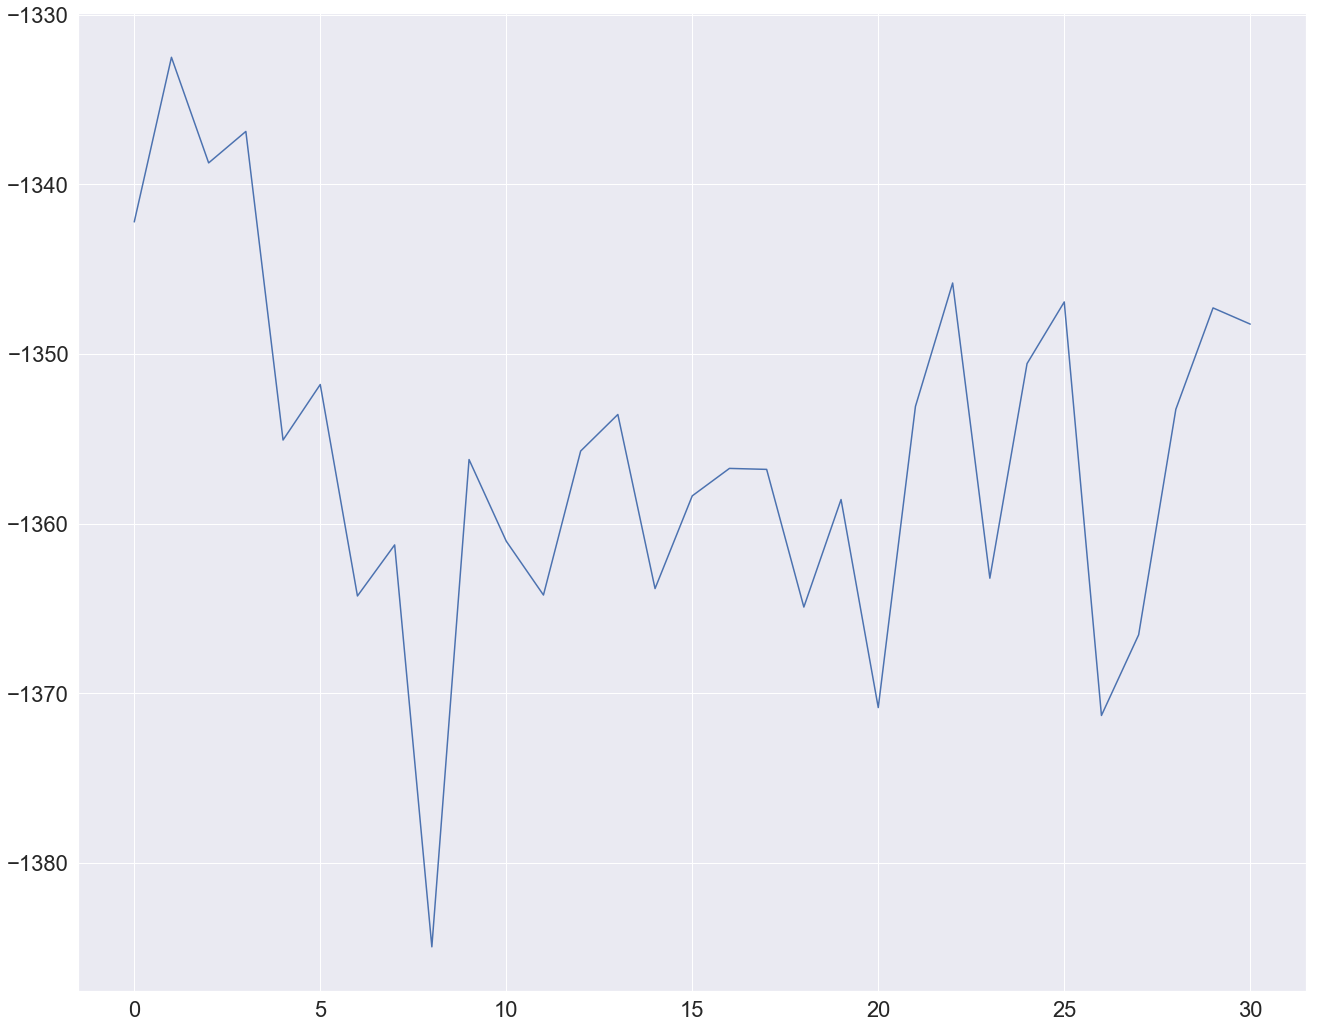

In [402]:
# plt.plot(result)
# plt.plot(er1)
# plt.plot(er2)
# plt.show()

In [318]:
def stand(x):
    return (x - mean(x))/std(x)

In [471]:
best_mse = np.inf
best_param = 0

for i in np.arange(step):
    temperature = standardize(data["dG"]).rolling(i).mean()
    acceleration = standardize(data["T"]).rolling(i).mean()
    mse = ((temperature - acceleration)**2).mean()
    if mse < best_mse:
        best_mse = mse
        best_param = i

In [483]:
spearmanr(temperature.dropna(), acceleration.dropna())

SpearmanrResult(correlation=0.19315707025762352, pvalue=5.620946450141309e-37)

In [178]:
gap = 6*12
temperature = np.asanyarray(((data["dG"]).rolling(gap).mean().dropna()))
acceleration = np.asanyarray(((data["T"]).rolling(gap).mean().dropna()))
time_array = np.asanyarray(data.index[:temperature.shape[0]])/6/24

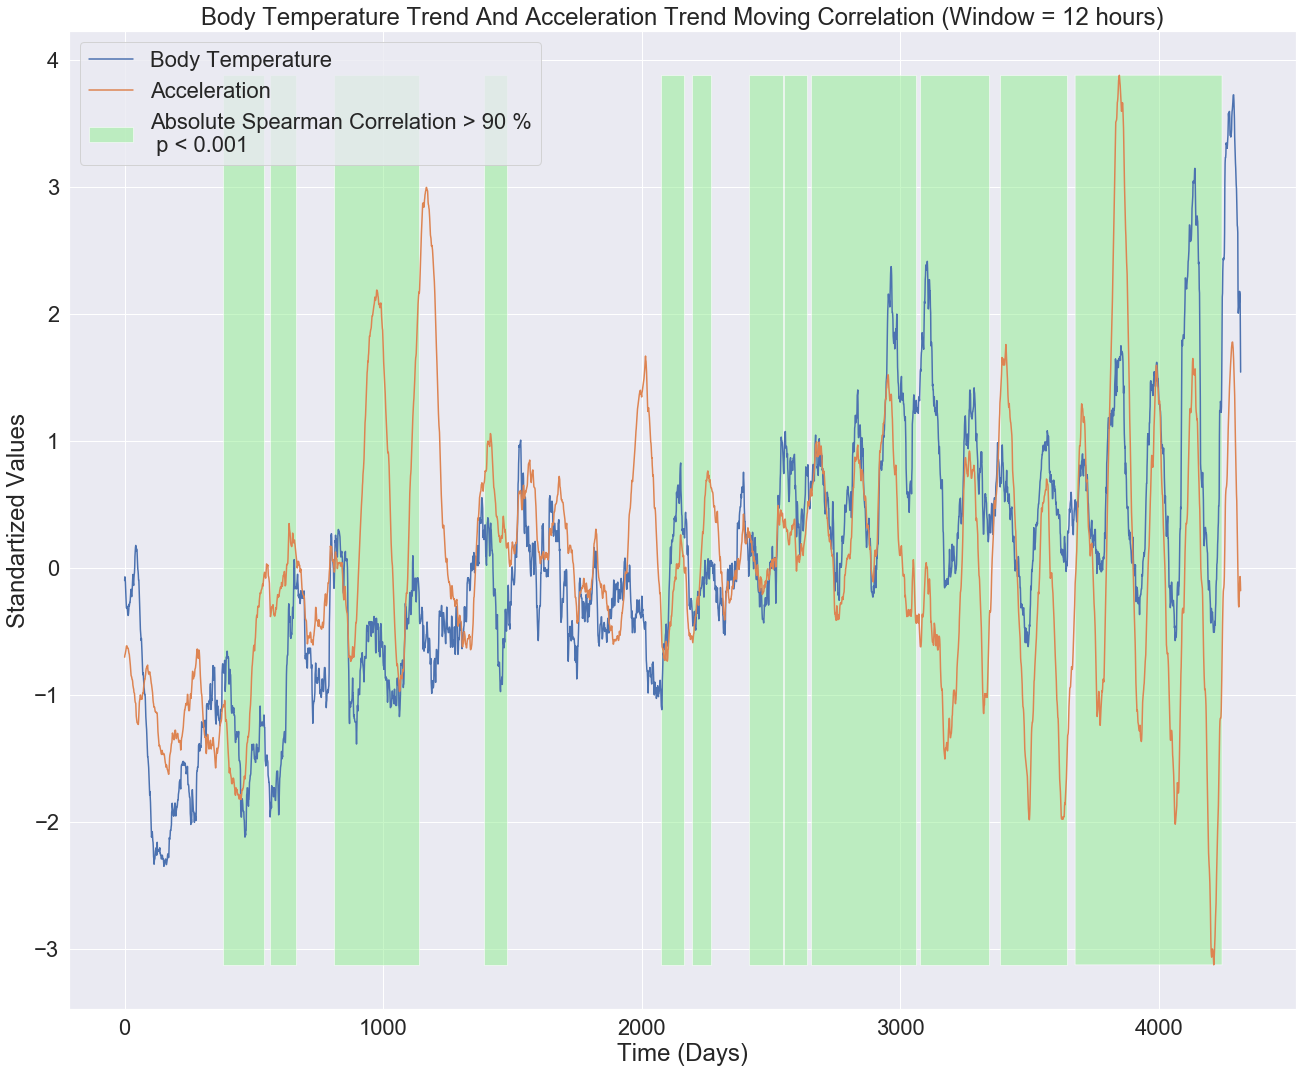

In [207]:
moving_correlation(time_array, temperature, acceleration, gap=6*12)

In [206]:
def moving_correlation(time_array, x, y, gap):

    time_array = np.arange(x.shape[0])

    # set size of the rolling window 

    p = np.zeros(x.shape[0]-gap) # p-value vector
    c = np.zeros(x.shape[0]-gap) # statistic vector

    # calculate the rolling corelation coefficient
    for i in np.arange(x.shape[0]-gap):
        ans = spearmanr(x[i:i+gap], y[i:i+gap])
        c[i] = ans[0] 
        p[i] = ans[1]

    p_adjusted = multipletests(p, method='bonferroni')[1]

    c1 = np.zeros(x.shape[0]-gap)
    c2 = np.zeros(x.shape[0]-gap)
    c3 = np.zeros(x.shape[0]-gap)

    c_green = np.zeros(x.shape[0]-gap)
    c_yellow = np.zeros(x.shape[0]-gap)
    c_red = np.zeros(x.shape[0]-gap)

    c1[(p_adjusted < 0.001) & (np.abs(c) >= 0.9)] = 1
    c2[(p_adjusted < 0.001) & (np.abs(c) >= 0.8) & (np.abs(c) < 0.9)] = 1
    c3[(p_adjusted < 0.001) & (np.abs(c) >= 0.7) & (np.abs(c) < 0.8)] = 1
    c1[c1 < 1] = 0
    c2[c2 < 1] = 0
    c3[c3 < 1] = 0

    num = [c1, c2, c3]
    col = [c_green, c_yellow, c_red]

    z = list(zip(num, col))

    counter = 0

    for unit in z:
        for i in range(len(unit[0])):
            if unit[0][i] == 0:
                if counter == 0:
                    unit[1][i] = NAN
                else:
                    unit[1][i] = time_array[i]
                    counter -= 1
            else:
                unit[1][i] = time_array[i]
                counter = gap

    z[2][1][z[1][1] == 1] = nan
    z[1][1][z[0][1] == 1] = nan
    z[2][1][z[0][1] == 1] = nan

    top = np.max([(standardize(x)).max(), (standardize(y)).max()])
    bottom = np.min([(standardize(x)).min(), (standardize(y)).min()])
    skip_start = 0
    
    tech = np.ones(z[0][1][:].shape[0])
    
#     plt.fill_between(z[2][1][:], tech*top, tech*bottom, alpha=0.5, facecolor="mistyrose", label = "60% > Absolute Spearman Correlation> 70%")
#     plt.fill_between(z[1][1][:], tech*top, tech*bottom, alpha=0.5, facecolor="lemonchiffon", label = "90% > Absolute Spearman Correlation > 80 %")
    plt.fill_between(z[0][1][:], tech*top, tech*bottom, alpha=0.5, facecolor="lightgreen", label = "Absolute Spearman Correlation > 90 %\nP-value < 0.001")
    plt.plot(time_array, standardize(x), label="Body Temperature")
    plt.plot(time_array, standardize(y), label="Acceleration")
    plt.title("Body Temperature And Acceleration Trend Moving Correlation (Window = 12 Hours)")
    plt.ylabel("Standartized Values")
    plt.xlabel("Time (Days)")
    plt.legend(loc="best")
    plt.show()